#**Grande Epidemia di Primavera**

##INIZIALIZZAZIONE E FUNZIONI UTILI

In [ ]:
%%capture
!   pip install adjustText
from adjustText import adjust_text
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import google.colab.drive
google.colab.drive.mount('/content/drive')
warnings.filterwarnings("ignore")

# Carica i dati
df = pd.read_csv('/content/drive/MyDrive/social_network/got_new/nodi_statistiche.csv')

In [ ]:
#centrality_metrics = ['clustering', 'eigencentrality', 'Authority', 'triangles', 'pageranks', 'degree', 'closnesscentrality', 'harmonicclosnesscentrality', 'betweenesscentrality', ]
centrality_metrics = ['degree', 'pageranks', 'eigencentrality', 'betweenesscentrality', 'Authority']

label_map = {
    'degree': 'Degree',
    'pageranks': 'PageRank',
    'eigencentrality': 'Eigenvector',
    'betweenesscentrality': 'Betweenness',
    'Authority': 'Authority',
}

Ecco un confronto tra i due scenari di epidemia (Peste Nera e COVID-19), usando i parametri storici e scientifici conosciuti:

---

### Parametri Simulazione

1. **Peste Nera**:
   - **Probabilità di contagio**: Alta (`0.3`) — La peste si diffondeva rapidamente in ambienti densamente popolati.
   - **Tasso di mortalità**: Molto alto (`0.5`) — Tra il 30-60% degli infetti moriva.
   - **Probabilità di guarigione**: Molto bassa (`0.05`) — Pochi sopravvivevano.
   - **Tempo minimo per guarire**: Lungo (`10` iterazioni) — La malattia aveva un decorso severo.
   - **Incremento per vicini morti**: Medio (`0.1`) — Le condizioni sociali e igieniche peggioravano con i decessi.

2. **COVID-19 (Inizio epidemia)**:
   - **Probabilità di contagio**: Medio-alta (`0.2`) — Il SARS-CoV-2 si diffondeva rapidamente.
   - **Tasso di mortalità**: Basso (`0.02`) — Decessi concentrati tra individui anziani o con comorbidità.
   - **Probabilità di guarigione**: Alta (`0.3`) — La maggior parte degli infetti guariva.
   - **Tempo minimo per guarire**: Breve (`7` iterazioni) — Periodo medio di isolamento.
   - **Incremento per vicini morti**: Molto basso (`0.01`) — La diffusione era indipendente dai decessi.

---

### Analisi dei risultati

1. **Peste Nera**:
   - Si prevede che un'alta percentuale della popolazione muoia a causa del tasso di mortalità elevato e della bassa probabilità di guarigione.
   - L'epidemia si diffonde rapidamente, ma tende a fermarsi quando un numero significativo di persone muore.

2. **COVID-19 (Inizio)**:
   - La diffusione è moderata, ma la mortalità rimane bassa.
   - Molti infetti guariscono, portando a un numero inferiore di decessi rispetto alla Peste Nera.


In [ ]:
def calculate_total_infected(row):
  """Calculates the total dead based on the given logic."""
  total_infected = 1 #c'è sempre almeno un infetto
  infected_cols = [col for col in row.index if col.startswith('Infected_')]
  for i in range(len(infected_cols) - 1):
    diff = row[infected_cols[i + 1]] - row[infected_cols[i]]
    if diff > 0:
      total_infected += diff
  return total_infected

def classify_epidemic(total_dead, total_cured, total_infected, total_population):
    """
    Classifies the epidemic based on the provided data, using estimated percentages.

    Args:
        total_dead (int): Total number of deaths.
        total_cured (int): Total number of cured individuals.
        total_infected (int): Total number of infected individuals.
        total_population (int): Total population.

    Returns:
        str: Label classifying the epidemic.
    """
    if total_population == 0:
        return "Popolazione Non Definita"

    # Calculate percentages and round to nearest 10
    dead_percentage = round(total_dead / total_population * 100, -1)
    cured_percentage = round(total_cured / total_population * 100, -1)
    infected_percentage = round(total_infected / total_population * 100, -1)

    # Create label string
    label = f"{int(infected_percentage)}-{int(dead_percentage)}-{int(cured_percentage)}"

    return label

def apply_classification_to_dataset(df):
    df['Etichetta'] = df.apply(lambda row: classify_epidemic(
        row['Total_Dead'], row['Total_Cured'], row['Total_Infected'], df.shape[0]
    ), axis=1)

In [ ]:
save_dir = '/content/drive/MyDrive/social_network/got_new/dati/'
# Percorsi dei file di output
covid_file_path = save_dir+'covid_results.csv'
plague_file_path = save_dir+'plague_results.csv'

# Carica i dataset
covid_df = pd.read_csv(f'{save_dir}covid_results.csv')
plague_df = pd.read_csv(f'{save_dir}plague_results.csv')

covid_df = covid_df.rename(columns={'Total_Infected': 'Last_Infected'})
plague_df = plague_df.rename(columns={'Total_Infected': 'Last_Infected'})

covid_df = covid_df.drop('Simulation', axis=1)
plague_df = plague_df.drop('Simulation', axis=1)

# Apply the function to create the 'Total_Dead' column
covid_df['Total_Infected'] = covid_df.apply(calculate_total_infected, axis=1)
plague_df['Total_Infected'] = plague_df.apply(calculate_total_infected, axis=1)

# Group by 'Character' and calculate the mean for other columns, handling NaN values
covid_avg = covid_df.groupby('Character').agg(
    lambda x: x.dropna().mean() if x.dtype != object else x.mode()[0]  # Handle numeric and categorical columns
).reset_index()

plague_avg = plague_df.groupby('Character').agg(
    lambda x: x.dropna().mean() if x.dtype != object else x.mode()[0]  # Handle numeric and categorical columns
).reset_index()

# Load edges from CSV
df = pd.read_csv('/content/drive/MyDrive/social_network/got_new/nodi_statistiche.csv')  # Replace 'edges.csv' with your file name
df = df.drop(['clustering', 'triangles', 'componentnumber', 'modularity_class', 'stat_inf_class', 'Label'], axis=1)

merged_covid_df = pd.merge(df, covid_avg, left_on='Id', right_on='Character', how='left')
merged_plague_df = pd.merge(df, plague_avg, left_on='Id', right_on='Character', how='left')
merged_covid_df = merged_covid_df.drop(columns=['Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality', 'weighted degree', 'Hub', 'Character'])

# Example usage:
apply_classification_to_dataset(merged_covid_df)
apply_classification_to_dataset(merged_plague_df)

In [ ]:
def trend_epidemic(df, ax=None, title='', n=None):
    one_plot = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        one_plot = True

    # Estrai colonne rilevanti
    dead_cols = [col for col in df.columns if col.startswith('Dead_')]
    cured_cols = [col for col in df.columns if col.startswith('Cured_')]
    infected_cols = [col for col in df.columns if col.startswith('Infected_')]

    # Calcola le medie per categoria nel tempo
    avg_dead = df[dead_cols].mean()
    avg_cured = df[cured_cols].mean()
    avg_infected = df[infected_cols].mean()

    # Estrai il numero del ciclo epidemico
    cycles = avg_dead.index.str.extract('(\d+)')[0].astype(int)

    # Crea il grafico con colori e stili migliorati
    ax.plot(cycles, avg_dead.values, label='Dead', color='#4d4d4d', linestyle='-', linewidth=2)
    ax.plot(cycles, avg_cured.values, label='Cured', color='#2ca02c', linestyle='-', linewidth=2)
    ax.plot(cycles, avg_infected.values, label='Infected', color='#d62728', linestyle='-', linewidth=2)

    # Linea verticale opzionale
    if n is not None:
        ax.axvline(x=n, color='gray', linestyle=':', linewidth=1.5, label=f'x = {n}')

    # Etichette e titolo
    ax.set_xlabel('Epidemic Cycles', fontsize=12)
    ax.set_ylabel('Average Number of Characters', fontsize=12)
    ax.set_title(f'{title} Trend', fontsize=14, pad=15)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Griglia per migliorare leggibilità
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

    # Aggiungi legenda
    ax.legend(title='Categories', fontsize=10, title_fontsize=12, loc='upper left', frameon=True)

    # Mostra il grafico se è chiamato senza subplot
    if one_plot:
        plt.tight_layout()
        plt.show()


In [ ]:
# Function to calculate quartile
def get_quartile(value, quartiles):
    if value < quartiles[0.25]:
        return 1
    elif value < quartiles[0.50]:
        return 2
    elif value < quartiles[0.75]:
        return 3
    else:
        return 4

In [ ]:
def trend_epidemic_centrality(measure):
    # Calculate quartiles for the given measure
    m_covid_df = merged_covid_df.copy()
    m_plague_df = merged_plague_df.copy()
    degree_quartiles = m_covid_df[measure].quantile([0.25, 0.50, 0.75])
    m_covid_df['Quartile'] = m_covid_df[measure].apply(lambda x: get_quartile(x, degree_quartiles))

    degree_quartiles = m_plague_df[measure].quantile([0.25, 0.50, 0.75])
    m_plague_df['Quartile'] = m_plague_df[measure].apply(lambda x: get_quartile(x, degree_quartiles))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  # Crea due subplot affiancati

    # Line styles for each quartile
    line_styles = {
        1: '-.',  # Dash-dot line for Quartile 1
        2: '--', # Dashed line for Quartile 2
        3: ':', # Solid line for Quartile 3
        4: '-',  # Dotted line for Quartile 4
    }

    # Define colors and line styles
    colors = {
        'Dead': ['#aaaaaa', '#555555', '#3f3f3f', '#000000'],  # 4 shades of purple to green for Dead
        'Cured': ['#85cc83', '#358532', '#025208', '#0df205'],  # 4 shades of yellow to teal for Cured
        'Infected': ['#fa575d', '#963b3e', '#801317', '#f7020b']  # 4 shades of yellow to dark red for Infected
    }

    legend_elements = [
            mpatches.Patch(color='black', label='Dead'),
            mpatches.Patch(color='seagreen', label='Cured'),
            mpatches.Patch(color='red', label='Infected'),
            mlines.Line2D([0], [0], color='gray', linestyle='-', label='Quartile 1'), # Changed to mlines.Line2D
            mlines.Line2D([0], [0], color='gray', linestyle='--', label='Quartile 2'), # Changed to mlines.Line2D
            mlines.Line2D([0], [0], color='gray', linestyle='-.', label='Quartile 3'), # Changed to mlines.Line2D
            mlines.Line2D([0], [0], color='gray', linestyle=':', label='Quartile 4')  # Changed to mlines.Line2D
        ]

    # Generate plots for COVID-19 and Plague
    for title, df, ax in zip(['COVID-19', 'Plague'], [m_covid_df, m_plague_df], axes):
        for quartile in range(1, 5):
            quartile_data = df[df['Quartile'] == quartile]

            # Extract columns related to Dead, Cured, and Infected
            dead_cols = [col for col in quartile_data.columns if col.startswith('Dead_')]
            cured_cols = [col for col in quartile_data.columns if col.startswith('Cured_')]
            infected_cols = [col for col in quartile_data.columns if col.startswith('Infected_')]

            # Calculate the average for each category over time
            avg_dead = quartile_data[dead_cols].mean()
            avg_cured = quartile_data[cured_cols].mean()
            avg_infected = quartile_data[infected_cols].mean()

            # Create a plot to visualize the trends with custom colors
            ax.plot(avg_dead.index.str.extract('(\d+)')[0].astype(int), avg_dead.values, label=f'Dead - Quartile {quartile}', color=colors['Dead'][quartile - 1], linestyle=line_styles[quartile])
            ax.plot(avg_cured.index.str.extract('(\d+)')[0].astype(int), avg_cured.values, label=f'Cured - Quartile {quartile}', color=colors['Cured'][quartile - 1], linestyle=line_styles[quartile])
            ax.plot(avg_infected.index.str.extract('(\d+)')[0].astype(int), avg_infected.values, label=f'Infected - Quartile {quartile}', color=colors['Infected'][quartile - 1], linestyle=line_styles[quartile])

        ax.set_xlabel('Epidemic cycles')
        ax.set_ylabel('Average number of characters')
        ax.set_title(f'{title}')
        ax.legend(handles=legend_elements, loc='upper right')

    plt.suptitle(f'{label_map.get(measure)} Trend', fontsize=16)

    plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
    plt.show()

In [ ]:
def trend_epidemic_centrality(measure):
    # Copia dei dataset per manipolazioni
    m_covid_df = merged_covid_df.copy()
    m_plague_df = merged_plague_df.copy()

    # Calcola i quartili per COVID-19
    covid_quartiles = m_covid_df[measure].quantile([0.25, 0.50, 0.75])
    m_covid_df['Quartile'] = m_covid_df[measure].apply(lambda x: get_quartile(x, covid_quartiles))

    # Calcola i quartili per la Peste
    plague_quartiles = m_plague_df[measure].quantile([0.25, 0.50, 0.75])
    m_plague_df['Quartile'] = m_plague_df[measure].apply(lambda x: get_quartile(x, plague_quartiles))

    # Imposta il layout per i grafici
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    # Stili di linea e colori
    line_styles = ['-', '--', '-.', ':']
    colors = {
        'Dead': sns.color_palette("Greys", 4),
        'Cured': sns.color_palette("Greens", 4),
        'Infected': sns.color_palette("Reds", 4)
    }

    # Elementi della legenda
    legend_elements = [
        mpatches.Patch(color='black', label='Dead'),
        mpatches.Patch(color='green', label='Cured'),
        mpatches.Patch(color='red', label='Infected'),
        mlines.Line2D([], [], color='black', linestyle='-', label='Quartile 1'),
        mlines.Line2D([], [], color='black', linestyle='--', label='Quartile 2'),
        mlines.Line2D([], [], color='black', linestyle='-.', label='Quartile 3'),
        mlines.Line2D([], [], color='black', linestyle=':', label='Quartile 4'),
    ]

    # Creazione dei grafici per COVID-19 e Plague
    for title, df, ax in zip(['COVID-19', 'Plague'], [m_covid_df, m_plague_df], axes):
        for quartile in range(1, 5):
            quartile_data = df[df['Quartile'] == quartile]

            # Estrai le colonne corrispondenti
            dead_cols = [col for col in quartile_data.columns if col.startswith('Dead_')]
            cured_cols = [col for col in quartile_data.columns if col.startswith('Cured_')]
            infected_cols = [col for col in quartile_data.columns if col.startswith('Infected_')]

            # Media delle categorie per ciclo epidemico
            avg_dead = quartile_data[dead_cols].mean()
            avg_cured = quartile_data[cured_cols].mean()
            avg_infected = quartile_data[infected_cols].mean()

            # Grafici
            ax.plot(
                avg_dead.index.str.extract(r'(\d+)')[0].astype(int), avg_dead.values,
                label=f'Dead Q{quartile}', color=colors['Dead'][quartile - 1], linestyle=line_styles[quartile - 1]
            )
            ax.plot(
                avg_cured.index.str.extract(r'(\d+)')[0].astype(int), avg_cured.values,
                label=f'Cured Q{quartile}', color=colors['Cured'][quartile - 1], linestyle=line_styles[quartile - 1]
            )
            ax.plot(
                avg_infected.index.str.extract(r'(\d+)')[0].astype(int), avg_infected.values,
                label=f'Infected Q{quartile}', color=colors['Infected'][quartile - 1], linestyle=line_styles[quartile - 1]
            )

        ax.set_xlabel('Epidemic Cycles', fontsize=12)
        ax.set_ylabel('Average Characters', fontsize=12)
        ax.set_title(f'{title} Trends', fontsize=14)
        ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend = None
        #ax.legend(handles=legend_elements, loc='best', ncol=2, fontsize=10)


    # Imposta legenda generale
    #fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=10, frameon=False)
    # Titolo generale e layout
    plt.suptitle(f'Trends in {label_map.get(measure)} Across Epidemic Quartiles', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def plot_quartile_correlation(df, title, metrics, y_measure, palette='viridis'):
    plt.figure(figsize=(10, 4))  # Crea una figura di dimensioni appropriate

    # Creiamo un dataframe vuoto che conterrà tutti i dati combinati
    combined_data = []

    # Per ogni metrica, calcoliamo i quartili e prepariamo i dati
    for metric in metrics:
        # Calcola i quartili per la metrica di centralità
        quartiles = df[metric].quantile([0.25, 0.50, 0.75])

        # Assegna i quartili a ciascun punto dati
        df['Quartile_Temp'] = df[metric].apply(lambda x: get_quartile(x, quartiles))

        # Creiamo un dataframe temporaneo per la metrica corrente
        temp_df = df[['Quartile_Temp', y_measure]].copy()
        temp_df['Metric'] = metric  # Aggiungiamo la metrica per ogni punto

        # Aggiungiamo il dataframe temporaneo alla lista combinata
        combined_data.append(temp_df)

    # Uniamo tutti i dati combinati in un unico dataframe
    combined_df = pd.concat(combined_data, ignore_index=True)

    # Sostituiamo i valori della colonna 'Metric' con le etichette personalizzate
    combined_df['Metric'] = combined_df['Metric'].map(label_map)

    # Crea un unico boxplot per tutte le metriche in un singolo grafico
    sns.boxplot(x='Quartile_Temp', y=y_measure, hue='Metric', data=combined_df, palette=palette)


    plt.title(f'{title} - Centrality Metrics Comparison')
    plt.xlabel('Quartile')
    plt.ylabel(f'Number of {y_measure}')
    plt.tight_layout()  # Ottimizza il layout per evitare sovrapposizioni
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def plot_epidemic_metrics(df, x_column):
    """
    Genera tre grafici affiancati che mostrano la relazione tra una colonna specifica (asse x)
    e le medie degli infetti, dei guariti e dei morti (asse y).

    Args:
        df (pd.DataFrame): Il DataFrame contenente i dati.
        x_column (str): Il nome della colonna da usare per l'asse X.
    """
    # Calcolo delle medie per infetti, guariti e morti
    avg_infected = df.groupby(x_column)['Total_Infected'].mean()
    avg_cured = df.groupby(x_column)['Total_Cured'].mean()
    avg_dead = df.groupby(x_column)['Total_Dead'].mean()

    # Configura il layout dei grafici
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
    colors = ['#d62728','#1d232b', '#2ca02c']  # Blu, Verde, Rosso

    # Grafico 1: Infetti medi
    sns.scatterplot(x=avg_infected.index, y=avg_infected.values, ax=axes[0], marker='o', color=colors[0], linewidth=0.2)
    axes[0].set_title("Infected vs " + x_column, fontsize=14)
    axes[0].set_xlabel(x_column, fontsize=12)
    axes[0].set_ylabel("Avg. Infected", fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].tick_params(axis='both', labelsize=10)

    # Grafico 2: Guariti medi
    sns.scatterplot(x=avg_cured.index, y=avg_cured.values, ax=axes[1], marker='o', color=colors[1], linewidth=0.2)
    axes[1].set_title("Cured vs " + x_column, fontsize=14)
    axes[1].set_xlabel(x_column, fontsize=12)
    axes[1].set_ylabel("Avg. Cured", fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].tick_params(axis='both', labelsize=10)

    # Grafico 3: Morti medi
    sns.scatterplot(x=avg_dead.index, y=avg_dead.values, ax=axes[2], marker='o', color=colors[2], linewidth=0.2)
    axes[2].set_title("Dead vs " + x_column, fontsize=14)
    axes[2].set_xlabel(x_column, fontsize=12)
    axes[2].set_ylabel("Avg. Dead", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].tick_params(axis='both', labelsize=10)

    # Finalizza i grafici
    plt.tight_layout(pad=2.0)
    plt.show()


In [ ]:
def heatmap_centrality_vs_avg(df_covid, df_plague):
    """
    Genera due heatmap affiancate per mostrare la correlazione tra le misure di centralità
    e le medie di infetti, guariti e morti totali. Una heatmap mostra i valori originali,
    l'altra i valori scalati tra 0 e 1.

    Args:
        df (pd.DataFrame): DataFrame con i dati.
    """
    total_measures = ['Total_Infected', 'Total_Cured', 'Total_Dead']

    def heatmap_centrality_vs_avg_one(df, ax, title=''):
      corr_matrix = df[centrality_metrics + total_measures].corr()

      # Heatmap con valori originali
      sns.heatmap(corr_matrix.loc[centrality_metrics, total_measures], annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
      ax.set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Crea due subplot affiancati

    heatmap_centrality_vs_avg_one(df_covid, axes[0], 'COVID-19')
    heatmap_centrality_vs_avg_one(df_plague, axes[1], 'Plague')

    plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
    plt.show()

In [ ]:
# Usa la funzione per il dataset COVID-19 e Peste Nera con una metrica di esempio come 'Avg_Steps'
def filter_quartile(df, column, n):
    """
    Filtra il DataFrame per selezionare solo le righe che appartengono al primo quartile
    della colonna specificata.

    Args:
        df (pd.DataFrame): Il DataFrame da filtrare.
        column (str): La colonna su cui basare il calcolo dei quartili.

    Returns:
        pd.DataFrame: Il DataFrame filtrato per il primo quartile.
    """
    # Calcolare i quartili della colonna
    quartiles = df[column].quantile([0.25, 0.50, 0.75])

    # Applicare la funzione per determinare il quartile per ciascun valore
    df['Quartile'] = df[column].apply(lambda x: get_quartile(x, quartiles))

    quartile_df = df[df['Quartile'] == n]

    # Rimuovere la colonna temporanea 'Quartile'
    quartile_df = quartile_df.drop(columns=['Quartile'])

    return quartile_df

In [ ]:
def hist_label(df, ax, title='', label_order=None):
  if label_order is None:
    label_order = sorted(df['Etichetta'].unique(), reverse=True)

  sns.countplot(data=df, x='Etichetta', ax=ax, order=label_order, palette="viridis")

  ax.set_title(f'{title}')
  ax.set_xlabel('Label')
  ax.tick_params(axis='x', rotation=45)
  ax.set_ylabel('Frequency')

In [ ]:
def print_top_n(df, metric, n=5):
    # Sort the DataFrame by the given metric in descending order
    sorted_df = df.sort_values(by=metric, ascending=False)

    # Select the top n rows
    top_n = sorted_df.head(n)
    display(top_n.head(n))

def print_tops_n(df, n=5):
    print(f"\n Total Infected")
    print_top_n(df, 'Total_Infected', n=5)
    print(f"\n Total Dead")
    print_top_n(df, 'Total_Dead', n=5)
    print(f"\n Total Cured")
    print_top_n(df, 'Total_Cured', n=5)

In [ ]:
def plot_percentage_distribution(df, column, palette, title=''):
    """
    Crea un grafico a barre per visualizzare la distribuzione delle percentuali su un dataset.

    Args:
        df (pd.DataFrame): Il DataFrame contenente i dati.
        column (str): Il nome della colonna utilizzata per calcolare la percentuale (ad esempio, 'Total_Infected').
        palette (str): La palette dei colori per il grafico (default: "Reds_r").
    """
    # Calcola la percentuale rispetto al totale (in questo caso la colonna 'column' e la popolazione)
    df['Percentage'] = (df[column] / df.shape[0]) * 100

    # Calcola i range (bin di 5%)
    bins = range(0, 85, 5)  # Da 0 a 85 con step di 5
    labels = [f"{i}-{i+5}%" for i in bins[:-1]]  # Etichette per ogni intervallo
    df['Percentage_Range'] = pd.cut(df['Percentage'], bins=bins, labels=labels, right=False)

    # Conta quante istanze ci sono per ogni intervallo
    range_counts = df['Percentage_Range'].value_counts(sort=False)

    # Crea il grafico con Seaborn
    plt.figure(figsize=(8, 5))
    sns.barplot(x=range_counts.index.astype(str),  # Asse X con i range
                y=range_counts.values,             # Frequenze
                palette=palette)                   # Palette dei colori per le barre

    # Miglioramenti estetici
    plt.title(f"{title} - Distribution of the Percentage of {column}", fontsize=15)
    plt.xlabel("Percentage Range", fontsize=14)
    plt.ylabel("Number of Instances", fontsize=14)

    # Miglioramento delle etichette sull'asse X e Y
    plt.xticks(rotation=90, ha="right", fontsize=8)
    plt.yticks(fontsize=8)

    # Personalizzare il layout
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

#ANALISI

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [ ]:
num_addam_marbrand = len(covid_df[covid_df['Character'] == 'Addam-Marbrand'])
print(f"Numero di istanze per personaggio': {num_addam_marbrand}")

Numero di istanze per personaggio': 261


In [ ]:
print('\n\nCOVID-19')
print_tops_n(merged_covid_df.copy(), n=5)
print('\n\nPlague')
print_tops_n(merged_plague_df.copy(), n=5)



COVID-19

 Total Infected


Id  pageranks  degree  betweenesscentrality  \
64   Robert-Baratheon   0.008779      65              0.078228   
73       Asha-Greyjoy   0.005265      25              0.033025   
12              Varys   0.004487      34              0.009201   
20       Eddard-Stark   0.011485      74              0.078732   
120        Bran-Stark   0.008375      54              0.044911   

     eigencentrality  Authority  Avg_Steps  Total_Dead  Total_Cured  \
64          0.774229   0.194375  21.681992   53.616858   603.237548   
73          0.098513   0.022997  23.130268   54.620690   604.279693   
12          0.510594   0.129808  22.049808   55.199234   602.532567   
20          0.762143   0.191659  21.823755   53.785441   602.337165   
120         0.495709   0.122537  22.245211   54.609195   604.122605   

     Last_Infected  ...  Dead_34  Cured_34  Infected_34  Dead_35  Dead_36  \
64        2.547893  ...      NaN       NaN          NaN      NaN      NaN   
73        2.291188  ...      NaN       NaN          NaN      NaN      NaN   
12        2.482759  ...      NaN       NaN          NaN      NaN      NaN   
20        2.593870  ...      NaN       NaN          NaN      NaN      NaN   
120       2.440613  ...      NaN       NaN          NaN      NaN      NaN   

     Cured_35  Cured_36  Infected_35  Infected_36  Total_Infected  
64        NaN       NaN          NaN          NaN      411.586207  
73        NaN       NaN          NaN          NaN      409.980843  
12        NaN       NaN          NaN          NaN      407.931034  
20        NaN       NaN          NaN          NaN      407.735632  
120       NaN       NaN          NaN          NaN      407.000000  

[5 rows x 120 columns]


 Total Dead


Id  pageranks  degree  betweenesscentrality  \
11   Tywin-Lannister   0.006579      48              0.020670   
12             Varys   0.004487      34              0.009201   
167           Gendry   0.003237      20              0.012467   
202    Petyr-Baelish   0.006531      47              0.025899   
58      Jeor-Mormont   0.004335      28              0.017268   

     eigencentrality  Authority  Avg_Steps  Total_Dead  Total_Cured  \
11          0.628177   0.159782  22.122605   55.593870   601.704981   
12          0.510594   0.129808  22.049808   55.199234   602.532567   
167         0.159112   0.040039  22.977011   55.076628   603.892720   
202         0.601496   0.152962  22.053640   55.026820   602.203065   
58          0.185984   0.042284  22.471264   54.992337   601.632184   

     Last_Infected  ...  Dead_34  Cured_34  Infected_34  Dead_35  Dead_36  \
11        2.383142  ...      NaN       NaN          NaN      NaN      NaN   
12        2.482759  ...      NaN       NaN          NaN      NaN      NaN   
167       2.639847  ...      NaN       NaN          NaN      NaN      NaN   
202       2.421456  ...      NaN       NaN          NaN      NaN      NaN   
58        2.938697  ...      NaN       NaN          NaN      NaN      NaN   

     Cured_35  Cured_36  Infected_35  Infected_36  Total_Infected  
11        NaN       NaN          NaN          NaN      406.084291  
12        NaN       NaN          NaN          NaN      407.931034  
167       NaN       NaN          NaN          NaN      401.616858  
202       NaN       NaN          NaN          NaN      404.816092  
58        NaN       NaN          NaN          NaN      401.494253  

[5 rows x 120 columns]


 Total Cured


Id  pageranks  degree  betweenesscentrality  \
59            Jon-Snow   0.019000     114              0.192120   
61        Mance-Rayder   0.004959      33              0.013605   
73        Asha-Greyjoy   0.005265      25              0.033025   
6    Joffrey-Baratheon   0.008865      69              0.031759   
138        Sansa-Stark   0.010185      75              0.048691   

     eigencentrality  Authority  Avg_Steps  Total_Dead  Total_Cured  \
59          0.615016   0.144182  21.766284   54.195402   605.800766   
61          0.222738   0.050948  22.471264   53.363985   604.540230   
73          0.098513   0.022997  23.130268   54.620690   604.279693   
6           0.843277   0.214379  21.942529   53.850575   604.187739   
138         0.807674   0.205847  21.919540   53.731801   604.180077   

     Last_Infected  ...  Dead_34  Cured_34  Infected_34  Dead_35  Dead_36  \
59        2.643678  ...      NaN       NaN          NaN      NaN      NaN   
61        2.681992  ...      NaN       NaN          NaN      NaN      NaN   
73        2.291188  ...      NaN       NaN          NaN      NaN      NaN   
6         2.547893  ...      NaN       NaN          NaN      NaN      NaN   
138       2.344828  ...      NaN       NaN          NaN      NaN      NaN   

     Cured_35  Cured_36  Infected_35  Infected_36  Total_Infected  
59        NaN       NaN          NaN          NaN      400.544061  
61        NaN       NaN          NaN          NaN      402.306513  
73        NaN       NaN          NaN          NaN      409.980843  
6         NaN       NaN          NaN          NaN      405.858238  
138       NaN       NaN          NaN          NaN      404.885057  

[5 rows x 120 columns]



Plague

 Total Infected


Id  pageranks  degree  Eccentricity  closnesscentrality  \
57        Janos-Slynt   0.003132      23             5            0.381844   
75      Balon-Greyjoy   0.002302      13             6            0.364679   
12              Varys   0.004487      34             6            0.401515   
328           Pycelle   0.003698      27             6            0.380383   
64   Robert-Baratheon   0.008779      65             5            0.459272   

     harmonicclosnesscentrality  betweenesscentrality  eigencentrality  \
57                     0.416017              0.007183         0.332018   
75                     0.392474              0.009546         0.175804   
12                     0.439350              0.009201         0.510594   
328                    0.416583              0.007406         0.435131   
64                     0.499769              0.078228         0.774229   

     weighted degree  Authority  ...  Dead_12 Cured_12  Infected_12  Dead_13  \
57               196   0.081741  ...      NaN      NaN          NaN      NaN   
75               149   0.043302  ...      NaN      NaN          NaN      NaN   
12               609   0.129808  ...      NaN      NaN          NaN      NaN   
328              357   0.111323  ...      NaN      NaN          NaN      NaN   
64              1488   0.194375  ...      NaN      NaN          NaN      NaN   

     Cured_13  Infected_13  Dead_14  Cured_14  Infected_14  Total_Infected  
57        NaN          NaN      NaN       NaN          NaN      350.928571  
75        NaN          NaN      NaN       NaN          NaN      350.626984  
12        NaN          NaN      NaN       NaN          NaN      350.511905  
328       NaN          NaN      NaN       NaN          NaN      350.503968  
64        NaN          NaN      NaN       NaN          NaN      350.238095  

[5 rows x 60 columns]


 Total Dead


Id  pageranks  degree  Eccentricity  closnesscentrality  \
138      Sansa-Stark   0.010185      75             6            0.433007   
59          Jon-Snow   0.019000     114             5            0.445378   
4    Jaime-Lannister   0.015461     101             6            0.451961   
68        Arya-Stark   0.013448      84             6            0.431362   
15        Robb-Stark   0.011081      74             5            0.444134   

     harmonicclosnesscentrality  betweenesscentrality  eigencentrality  \
138                    0.487044              0.048691         0.807674   
59                     0.513082              0.192120         0.615016   
4                      0.511572              0.100838         0.890040   
68                     0.488386              0.087242         0.687691   
15                     0.493920              0.066468         0.693603   

     weighted degree  Authority  ...  Dead_12 Cured_12  Infected_12  Dead_13  \
138             1547   0.205847  ...      NaN      NaN          NaN      NaN   
59              2757   0.144182  ...      NaN      NaN          NaN      NaN   
4               1569   0.226345  ...      NaN      NaN          NaN      NaN   
68              1460   0.172624  ...      NaN      NaN          NaN      NaN   
15              1424   0.173192  ...      NaN      NaN          NaN      NaN   

     Cured_13  Infected_13  Dead_14  Cured_14  Infected_14  Total_Infected  
138       NaN          NaN      NaN       NaN          NaN      340.940476  
59        NaN          NaN      NaN       NaN          NaN      332.694444  
4         NaN          NaN      NaN       NaN          NaN      336.710317  
68        NaN          NaN      NaN       NaN          NaN      338.007937  
15        NaN          NaN      NaN       NaN          NaN      341.412698  

[5 rows x 60 columns]


 Total Cured


Id  pageranks  degree  Eccentricity  closnesscentrality  \
146    Pate-(novice)   0.002227       7             7            0.215097   
201   Horton-Redfort   0.000813       4             8            0.235556   
435  Eldon-Estermont   0.000857       2             7            0.240036   
206  Cletus-Yronwood   0.001078       5             7            0.279438   
616     Hotho-Harlaw   0.001104       4             8            0.250947   

     harmonicclosnesscentrality  betweenesscentrality  eigencentrality  \
146                    0.227966              0.010042         0.002133   
201                    0.247294              0.000002         0.004874   
435                    0.248631              0.002516         0.001883   
206                    0.299781              0.000787         0.014645   
616                    0.264994              0.000591         0.004141   

     weighted degree  Authority  ...  Dead_12 Cured_12  Infected_12  Dead_13  \
146               47   0.000174  ...    402.0      0.0       237.75      NaN   
201               21   0.001115  ...      NaN      NaN          NaN      NaN   
435                6   0.000423  ...      NaN      NaN          NaN      NaN   
206               23   0.002844  ...      NaN      NaN          NaN      NaN   
616               16   0.000617  ...    419.0      0.0       235.50      NaN   

     Cured_13  Infected_13  Dead_14  Cured_14  Infected_14  Total_Infected  
146       NaN          NaN      NaN       NaN          NaN      270.865079  
201       NaN          NaN      NaN       NaN          NaN      250.976190  
435       NaN          NaN      NaN       NaN          NaN      118.654762  
206       NaN          NaN      NaN       NaN          NaN      277.055556  
616       NaN          NaN      NaN       NaN          NaN      253.357143  

[5 rows x 60 columns]

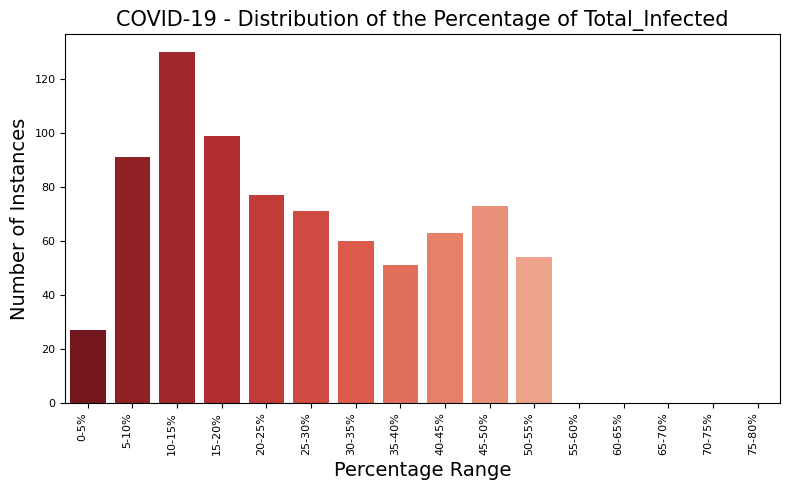

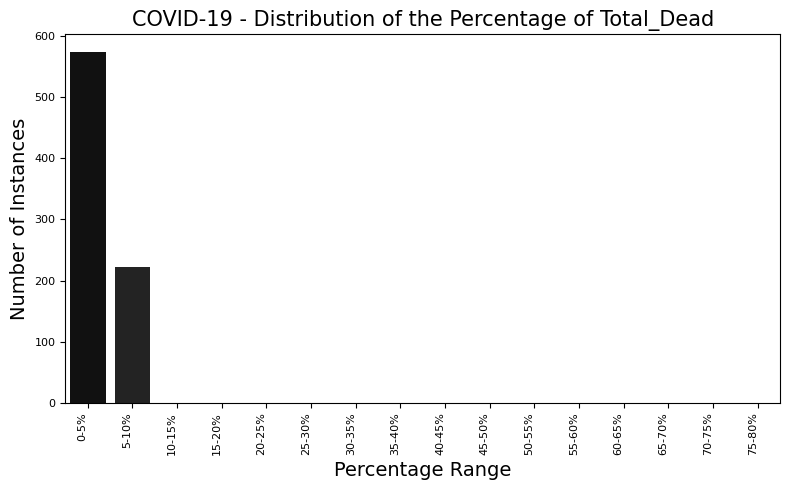

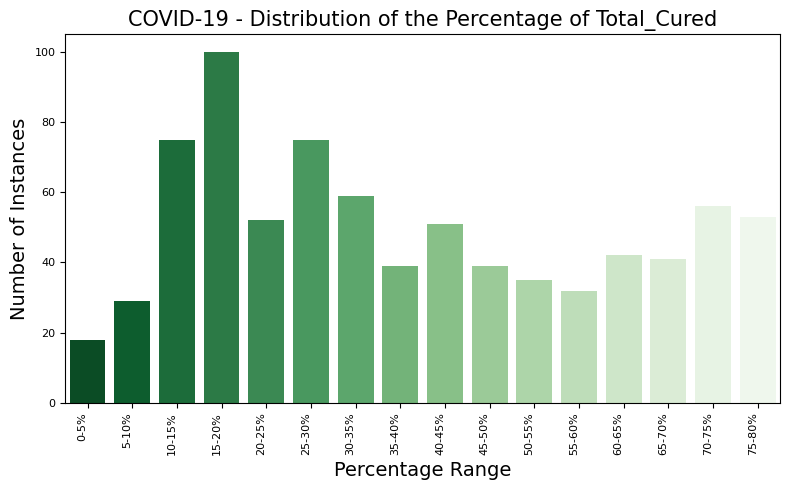

In [ ]:
df=merged_covid_df.copy()
plot_percentage_distribution(df, 'Total_Infected', palette="Reds_r", title='COVID-19')
plot_percentage_distribution(df, 'Total_Dead', palette="Greys_r", title='COVID-19')
plot_percentage_distribution(df, 'Total_Cured', palette="Greens_r", title='COVID-19')

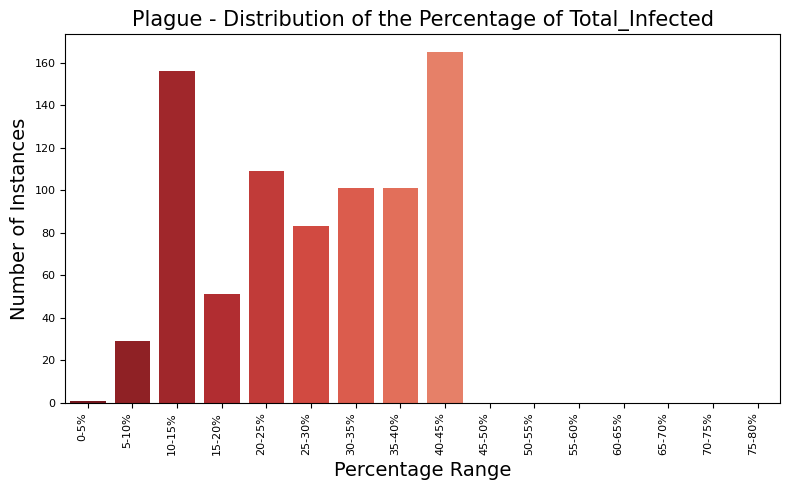

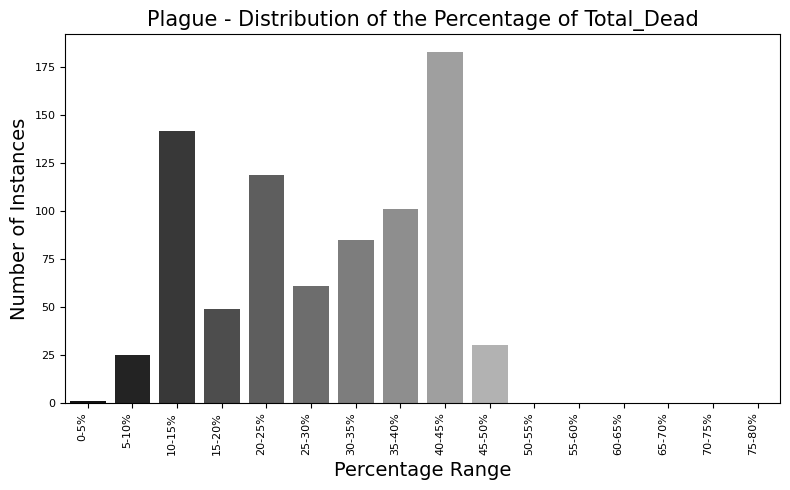

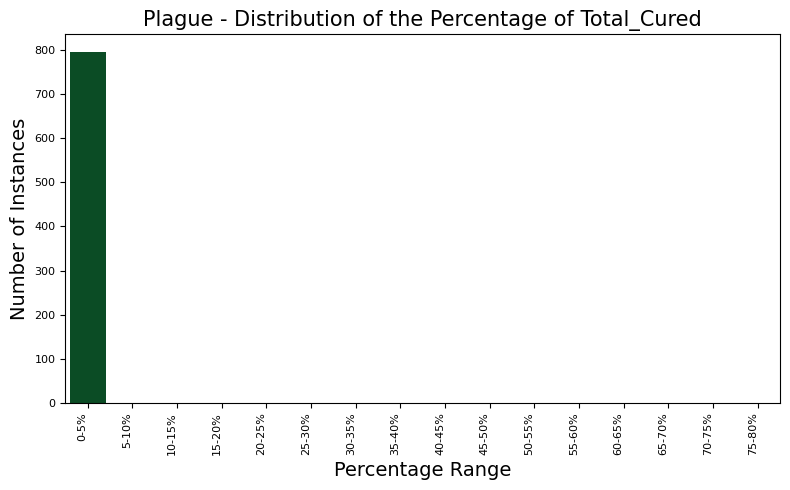

In [ ]:
df=merged_plague_df.copy()
plot_percentage_distribution(df, 'Total_Infected', palette="Reds_r", title='Plague')
plot_percentage_distribution(df, 'Total_Dead', palette="Greys_r", title='Plague')
plot_percentage_distribution(df, 'Total_Cured', palette="Greens_r", title='Plague')

##Andamento epidemia

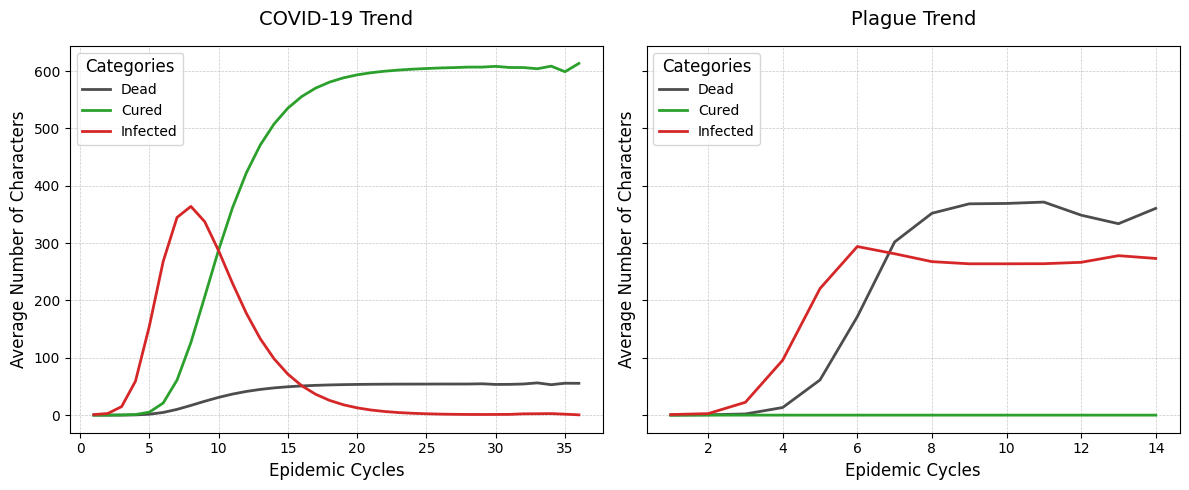

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Crea due subplot affiancati
trend_epidemic(merged_covid_df, ax=axes[0], title='COVID-19')
trend_epidemic(merged_plague_df, ax=axes[1], title='Plague')

plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
plt.show()

###Correlazione andamento

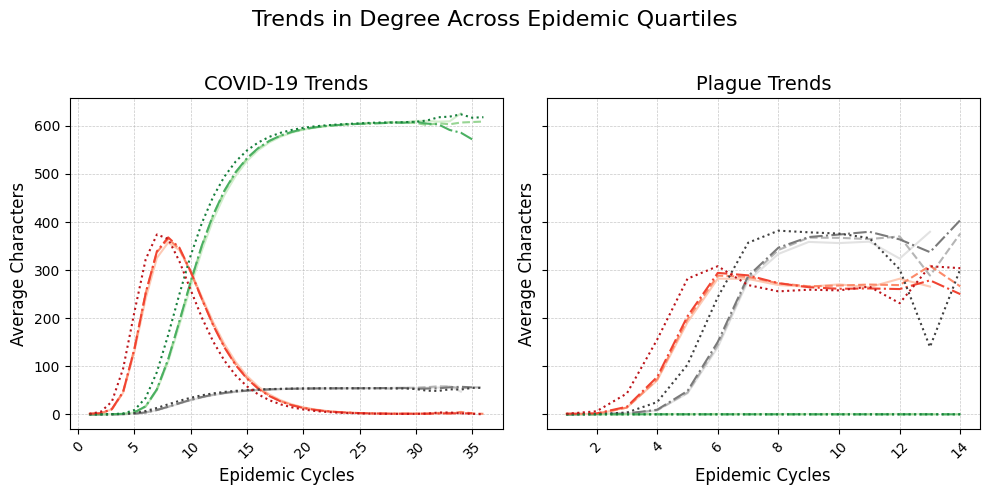

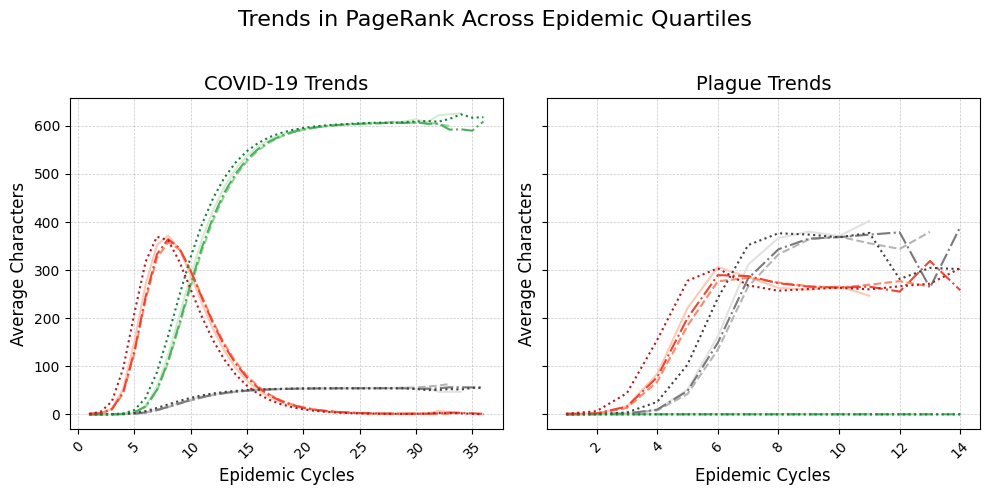

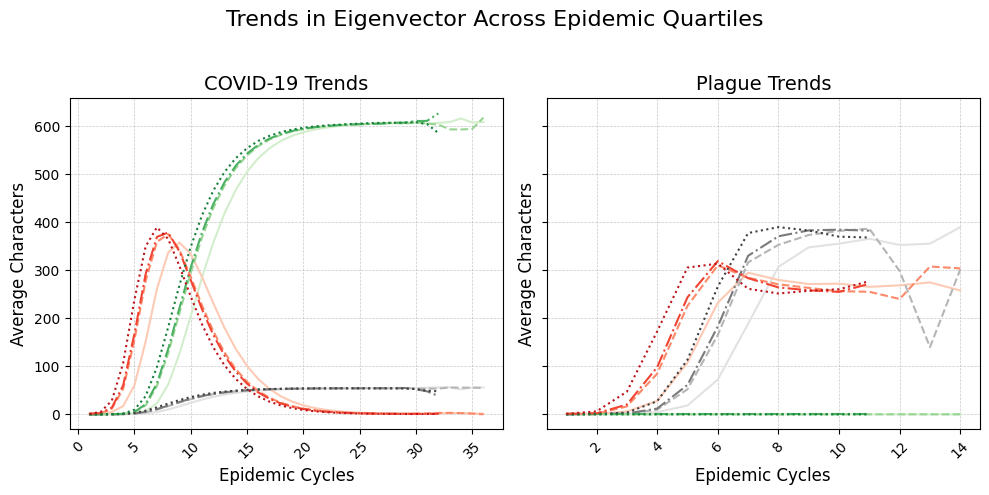

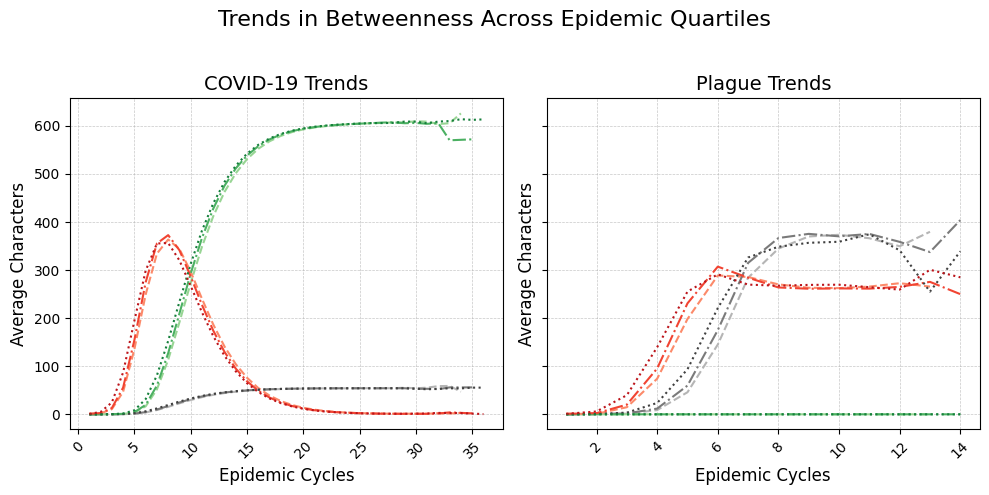

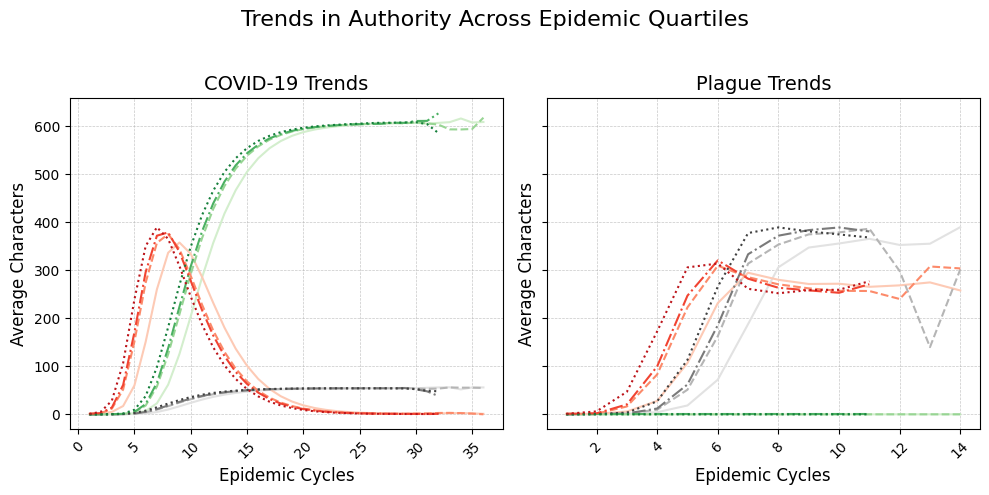

In [ ]:
for metric in centrality_metrics:
  trend_epidemic_centrality(metric)

##Correlazione numero di step

In [ ]:
def plot_quartile_correlation(df, title, metrics, y_measure, palette='viridis'):
    # Creazione della figura con dimensioni appropriate
    plt.figure(figsize=(14, 5))

    # Creiamo un dataframe vuoto che conterrà tutti i dati combinati
    combined_data = []

    # Calcoliamo i quartili e prepariamo i dati per ogni metrica
    for metric in metrics:
        quartiles = df[metric].quantile([0.25, 0.50, 0.75])  # Quartili
        df['Quartile_Temp'] = df[metric].apply(lambda x: get_quartile(x, quartiles))  # Quartile assignment

        temp_df = df[['Quartile_Temp', y_measure]].copy()
        temp_df['Metric'] = metric  # Assegna la metrica come colonna
        combined_data.append(temp_df)

    # Combina i dati di tutte le metriche
    combined_df = pd.concat(combined_data, ignore_index=True)

    # Sostituiamo i valori della colonna 'Metric' con le etichette personalizzate
    combined_df['Metric'] = combined_df['Metric'].map(label_map)

    # Crea il grafico con metriche sull'asse X e colore basato sui quartili
    sns.boxplot(
        x='Metric',
        y=y_measure,
        hue='Quartile_Temp',
        data=combined_df,
        palette=palette
    )

    # Miglioramenti estetici
    plt.title(f'{title} - Centrality Metrics by Quartile', fontsize=16, pad=20)
    plt.xlabel('', fontsize=12, labelpad=10)
    plt.ylabel(f'Number of {y_measure}', fontsize=12, labelpad=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Configura la legenda: posizionamento sotto il grafico
    legend = plt.legend(
        title='Quartile',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),  # Posiziona la legenda sotto il grafico
        ncol=4,  # Mostra le voci su 4 colonne
        fontsize=10,
        title_fontsize=12,
        #frameon=False  # Rimuove il bordo della legenda
    )

    # Ottimizza il layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Aggiunge spazio per la legenda sotto il grafico
    plt.show()


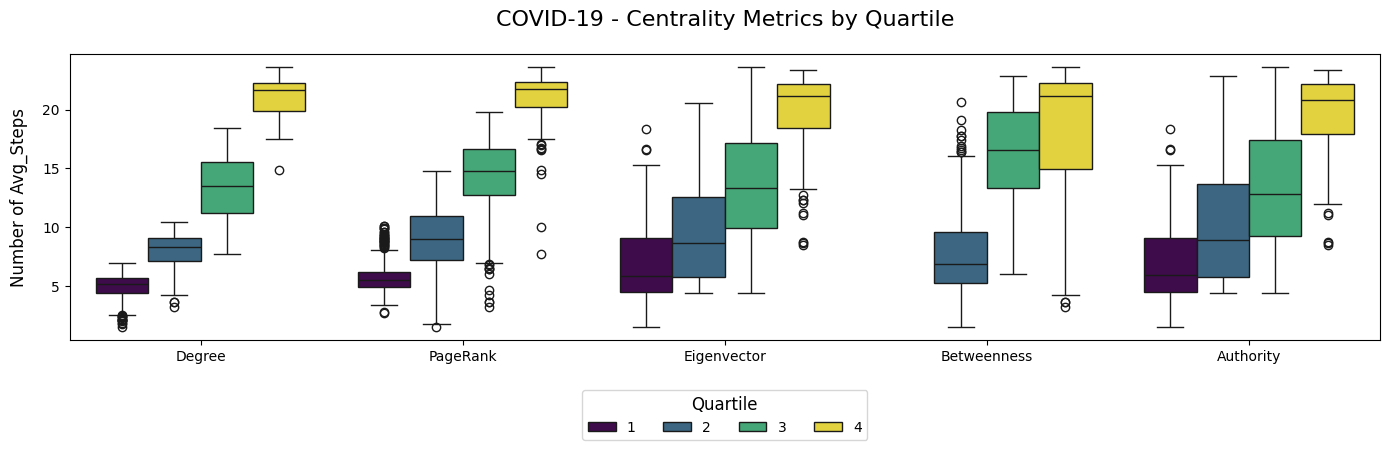

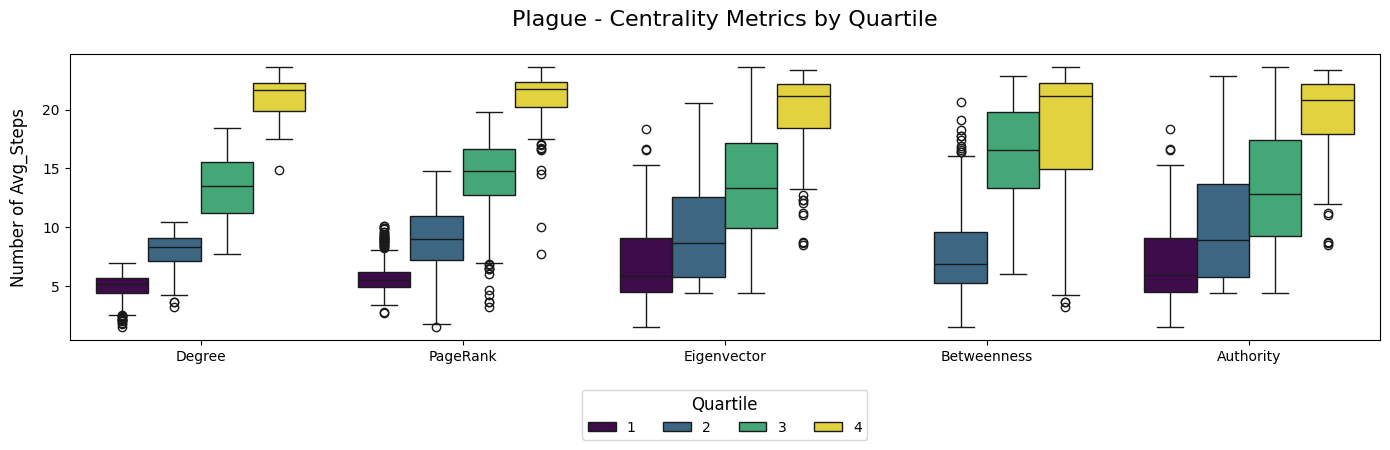

In [ ]:
# Genera i grafici per COVID-19 e peste
plot_quartile_correlation(merged_covid_df.copy(), 'COVID-19', centrality_metrics, y_measure='Avg_Steps')
plot_quartile_correlation(merged_covid_df.copy(), 'Plague', centrality_metrics, y_measure='Avg_Steps')

##Correlazione Infetti Morti Guariti

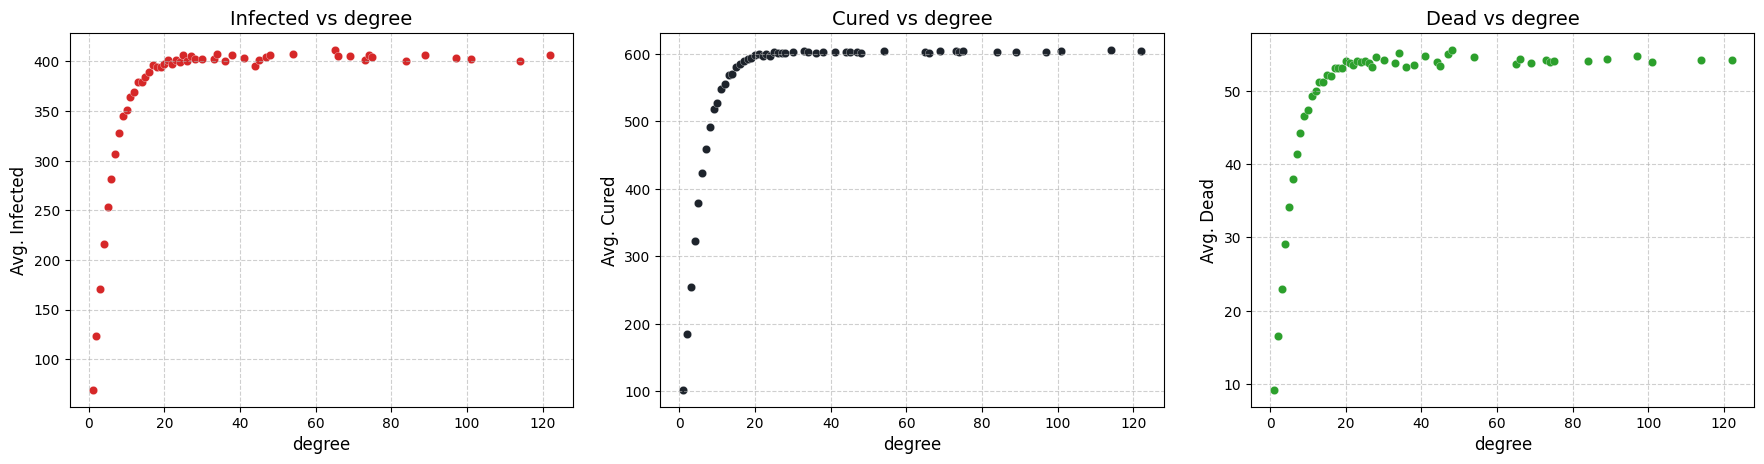

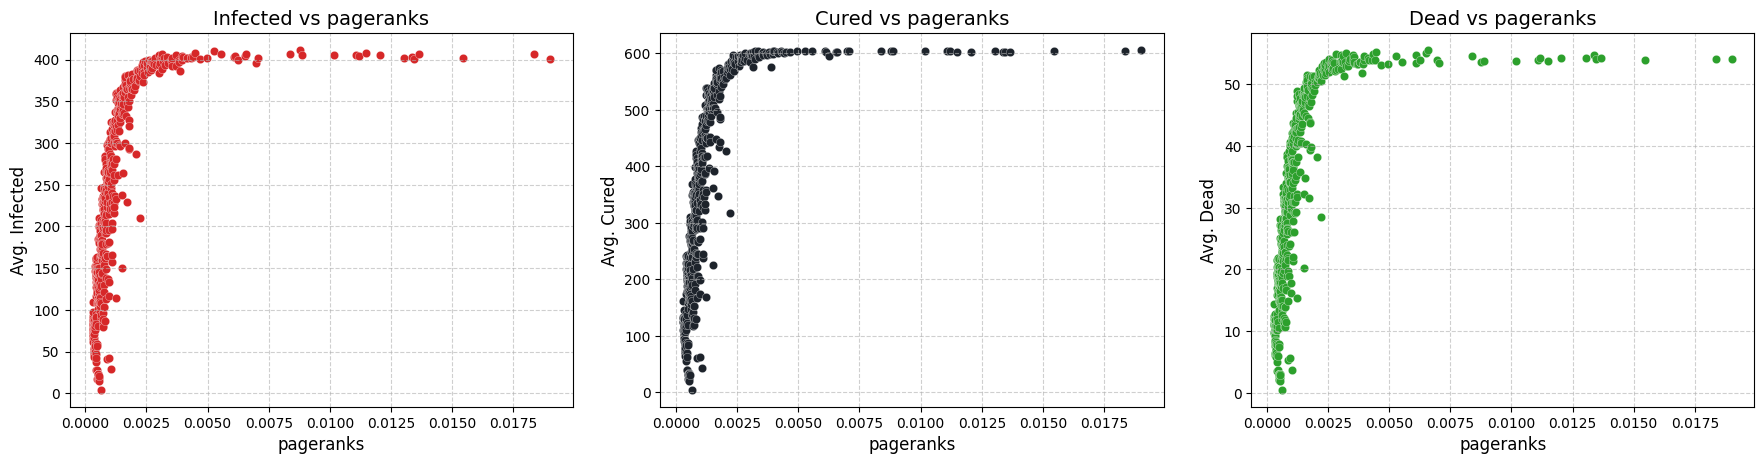

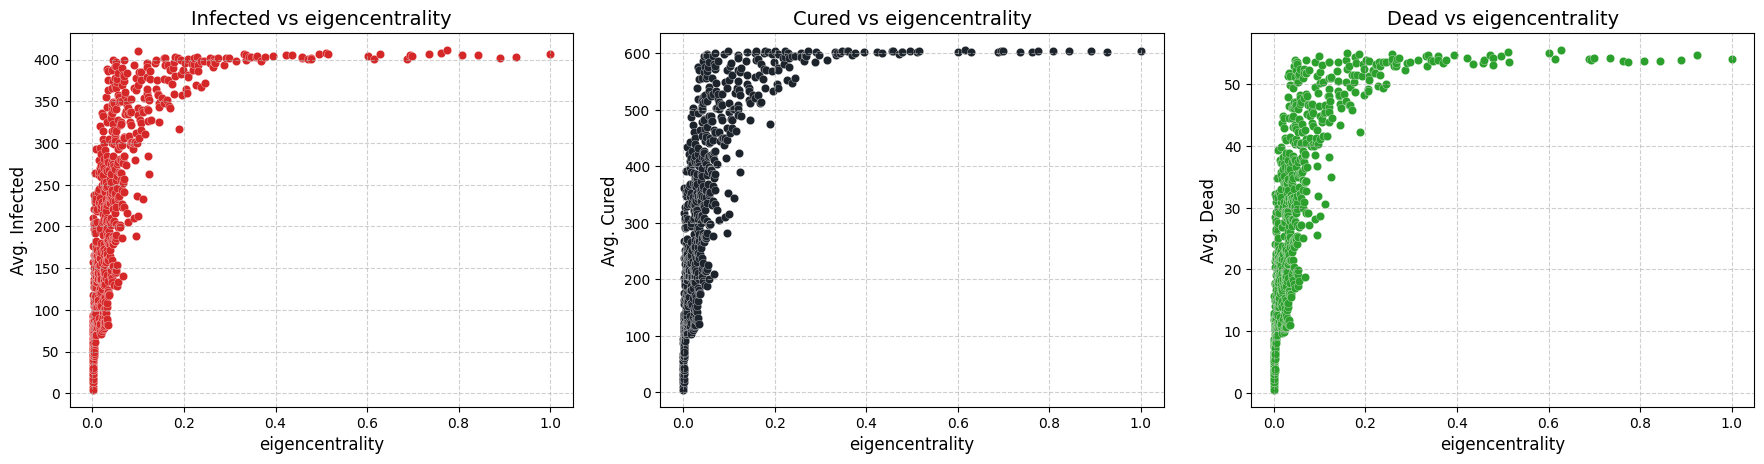

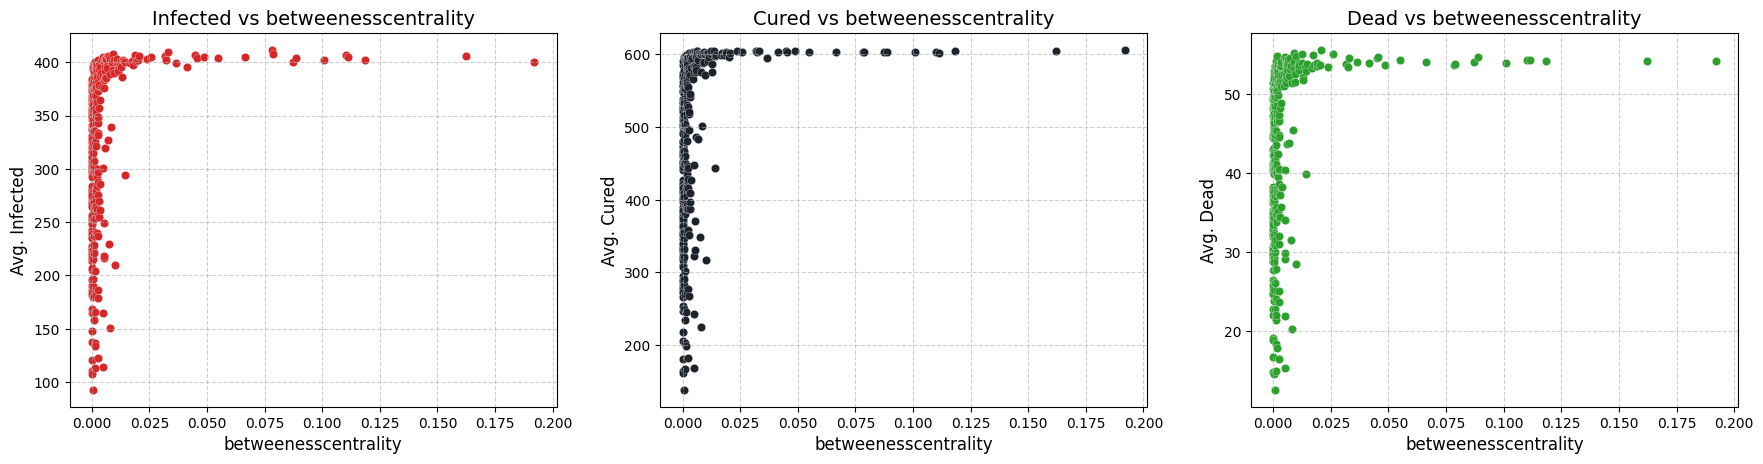

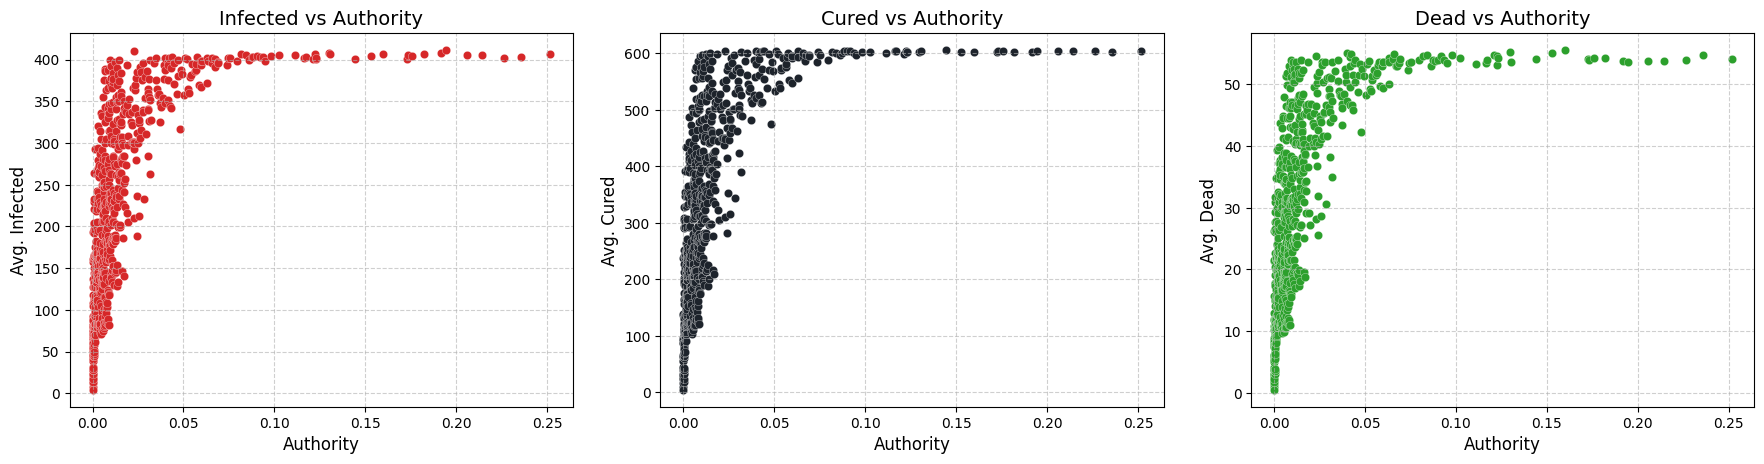

In [ ]:
for metric in centrality_metrics:
  plot_epidemic_metrics(merged_covid_df, metric)

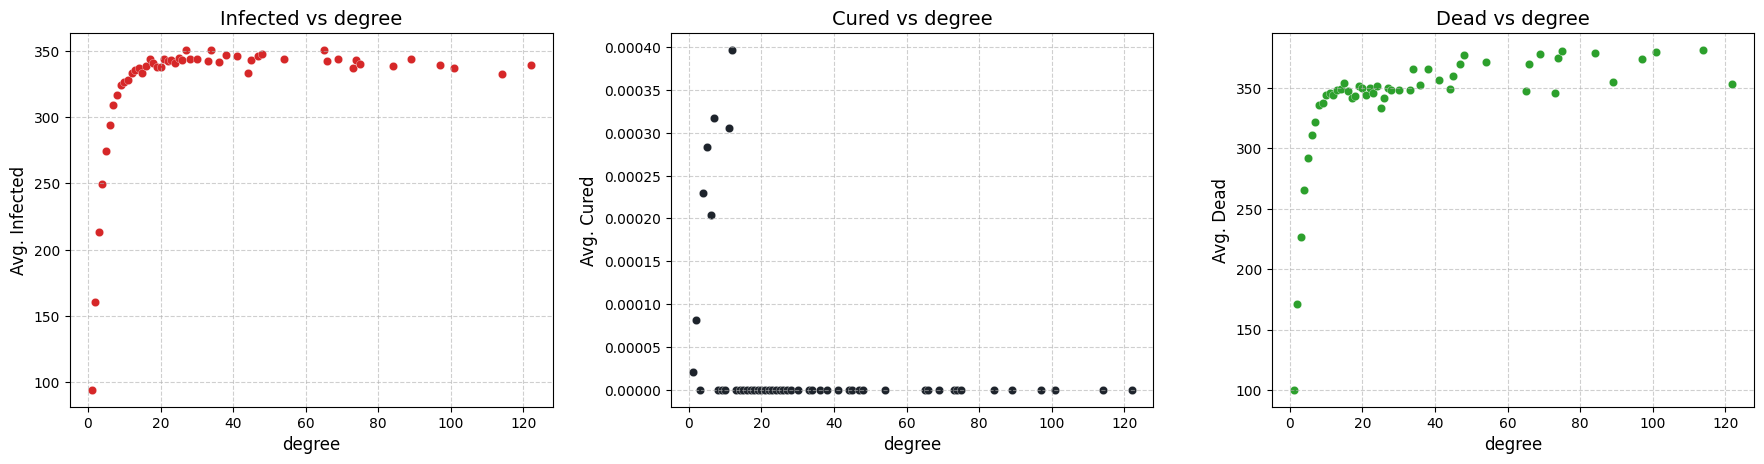

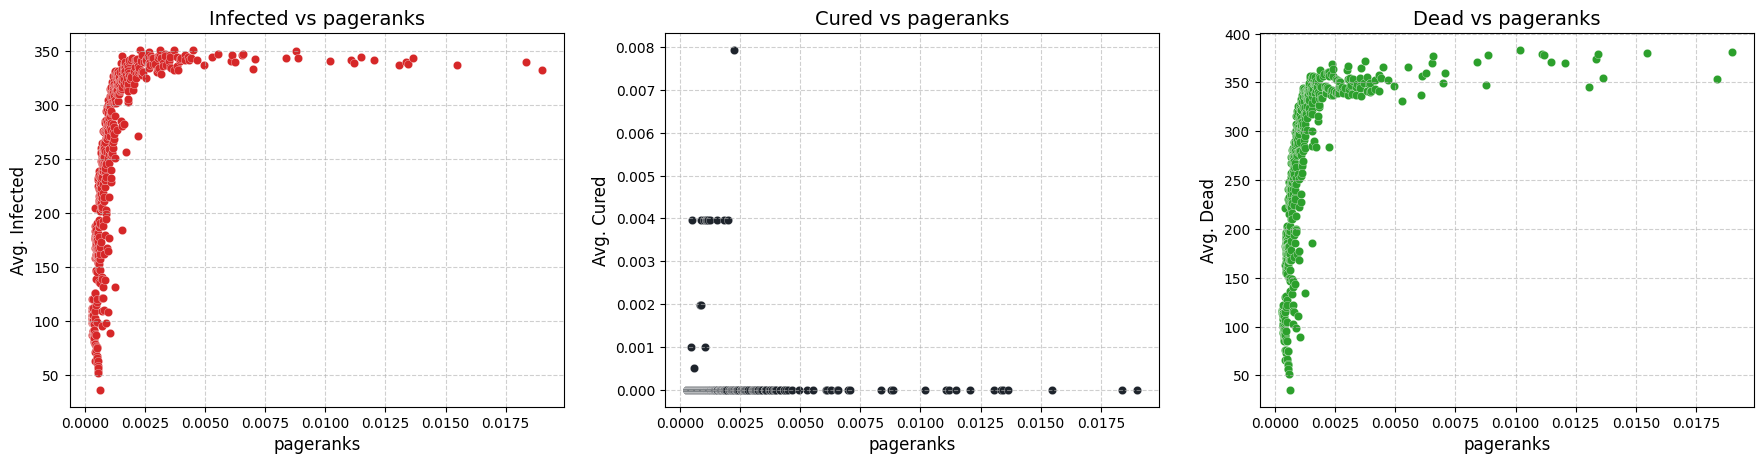

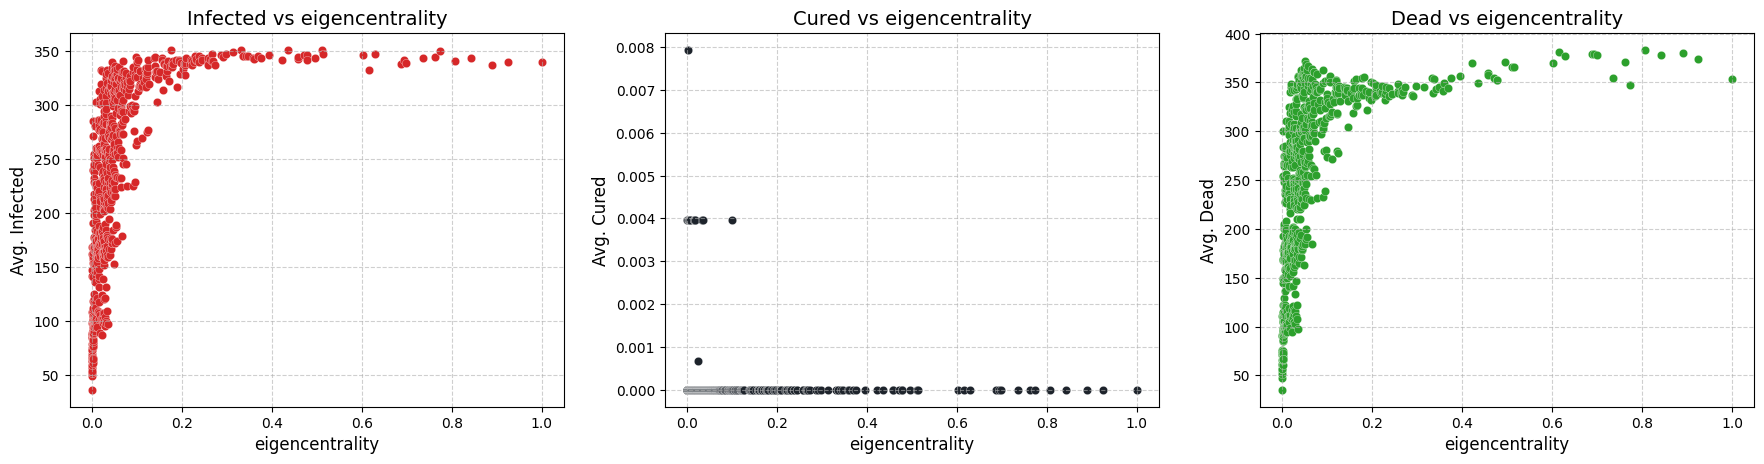

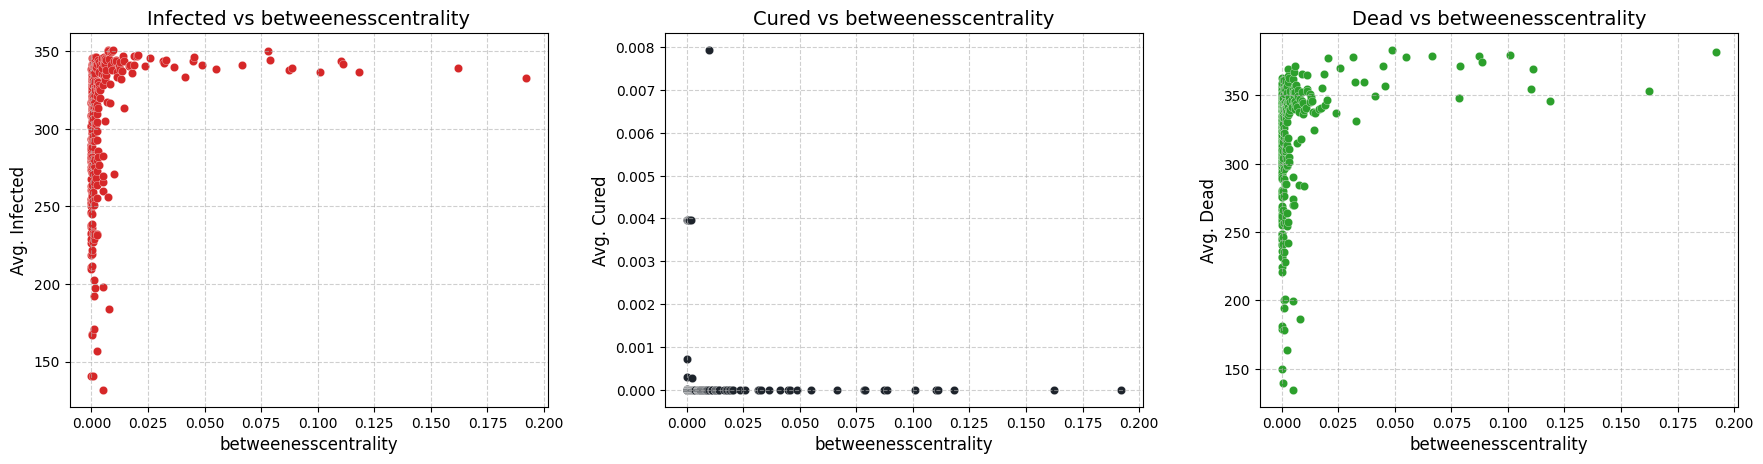

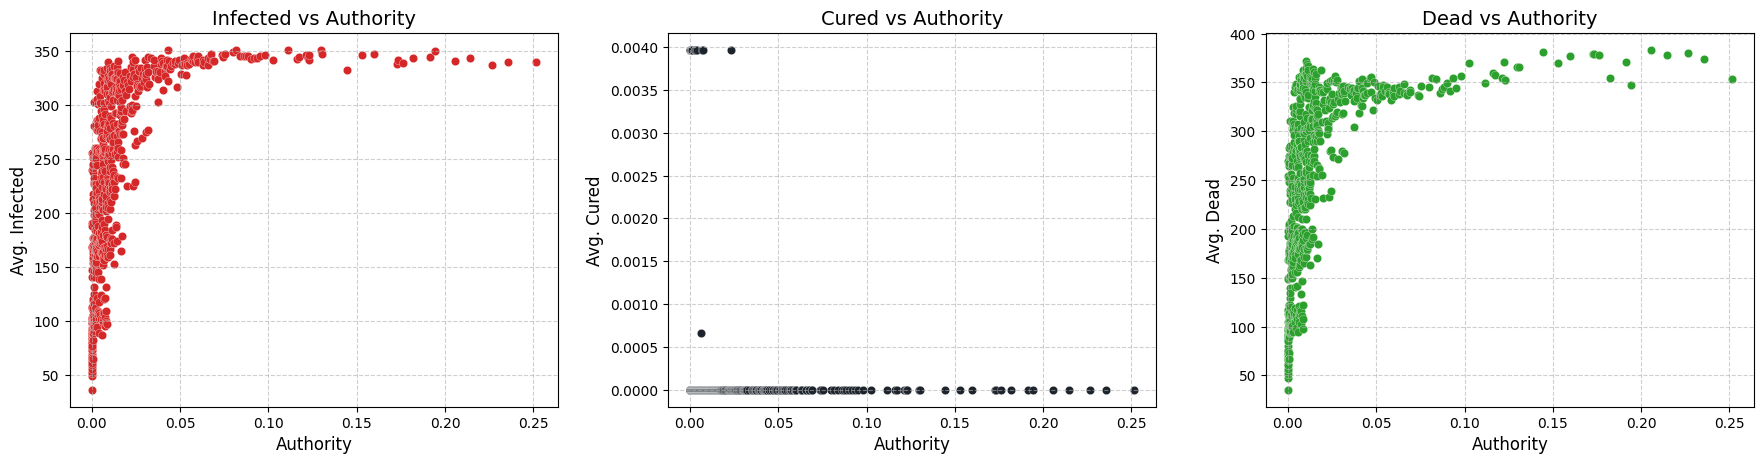

In [ ]:
for metric in centrality_metrics:
  plot_epidemic_metrics(merged_plague_df, metric)

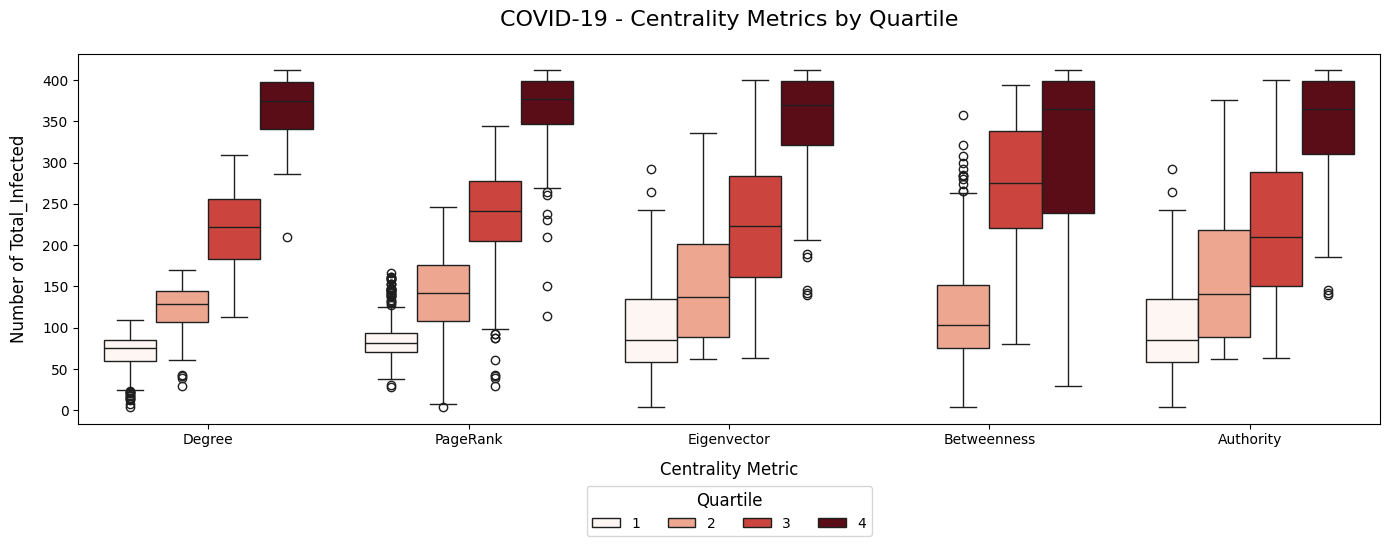

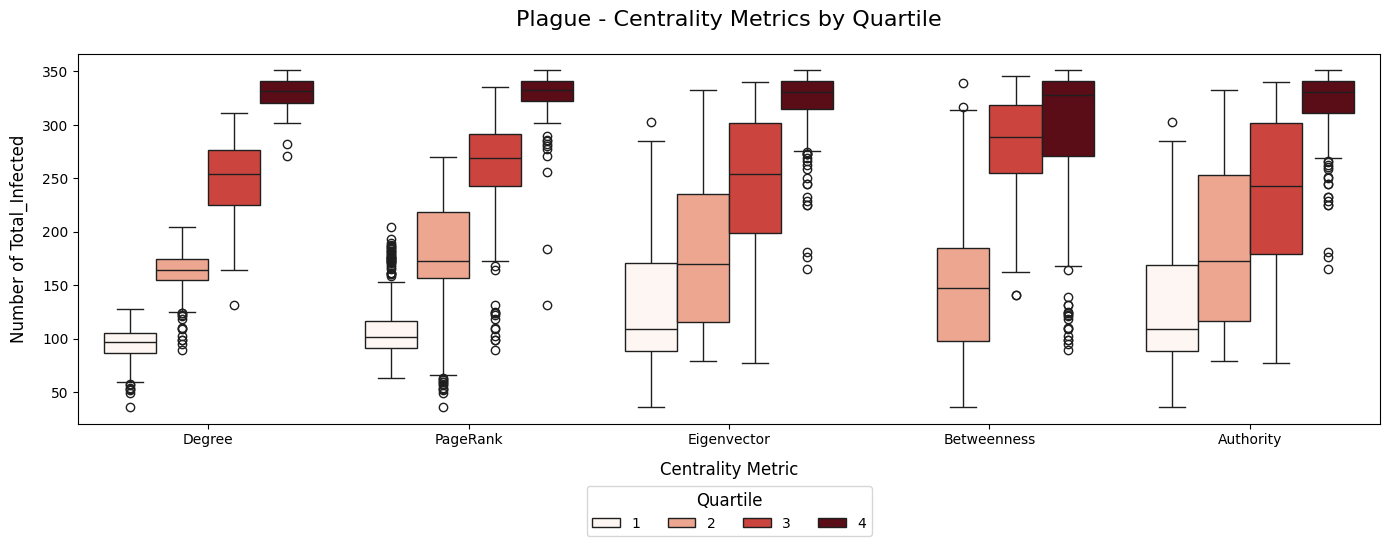

In [ ]:
# Genera i grafici INFETTI per COVID-19 e peste
plot_quartile_correlation(merged_covid_df.copy(), 'COVID-19', centrality_metrics, y_measure='Total_Infected', palette='Reds')
plot_quartile_correlation(merged_plague_df.copy(), 'Plague', centrality_metrics, y_measure='Total_Infected', palette='Reds')

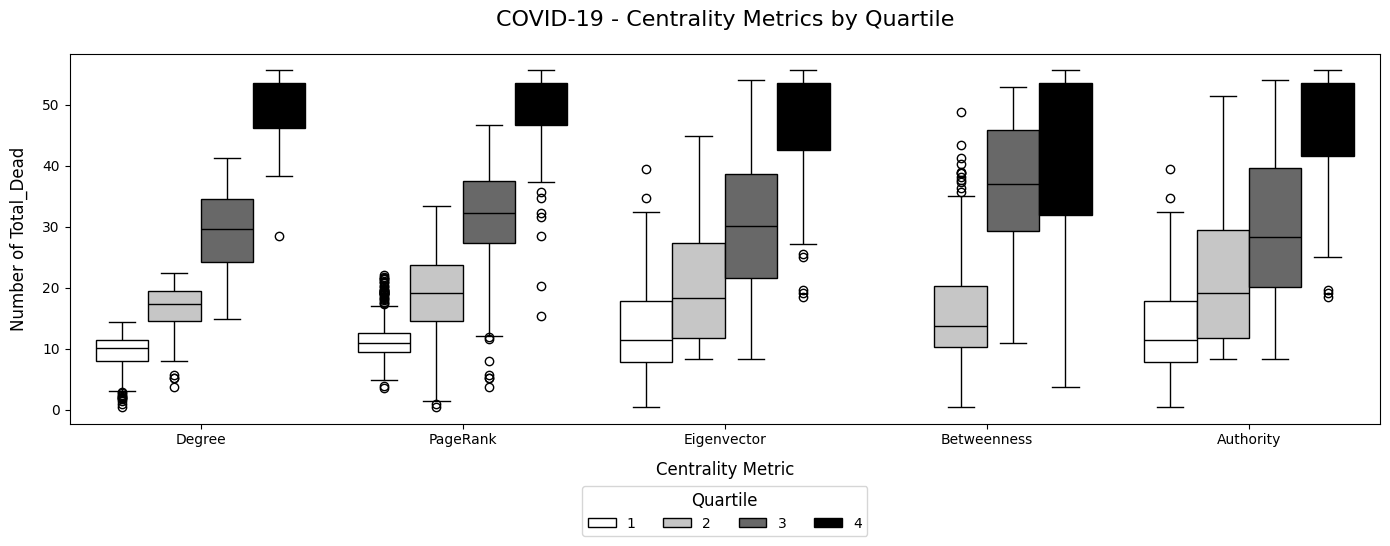

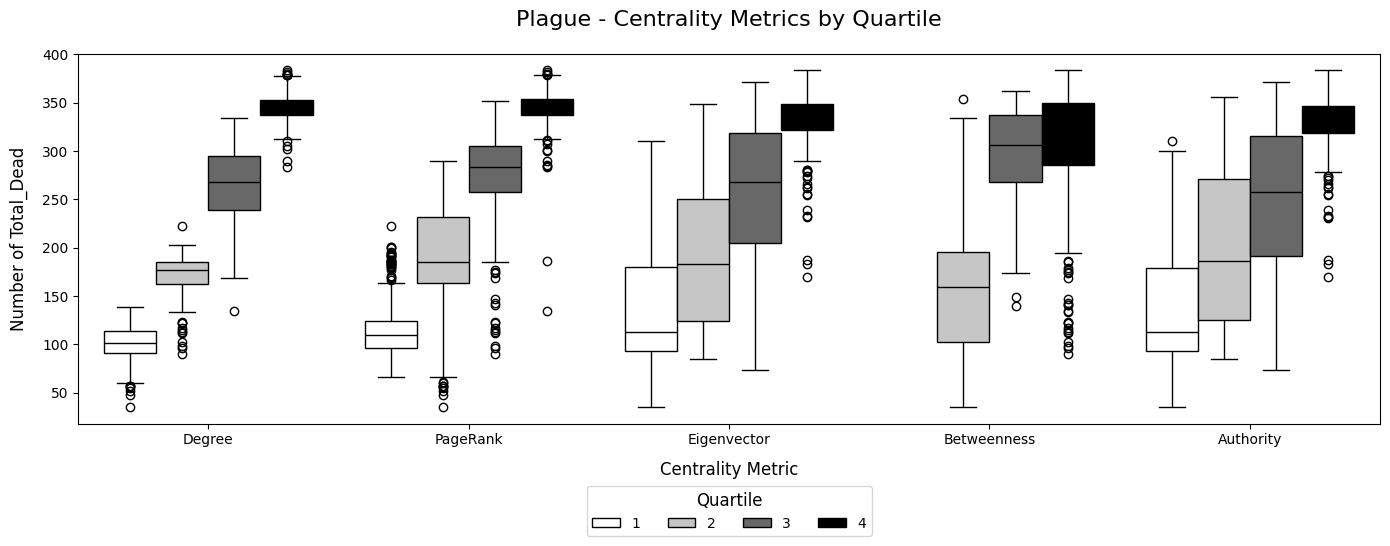

In [ ]:
# Genera i grafici MORTI per COVID-19 e peste
plot_quartile_correlation(merged_covid_df.copy(), 'COVID-19', centrality_metrics, y_measure='Total_Dead', palette='Grays')
plot_quartile_correlation(merged_plague_df.copy(), 'Plague', centrality_metrics, y_measure='Total_Dead', palette='Grays')

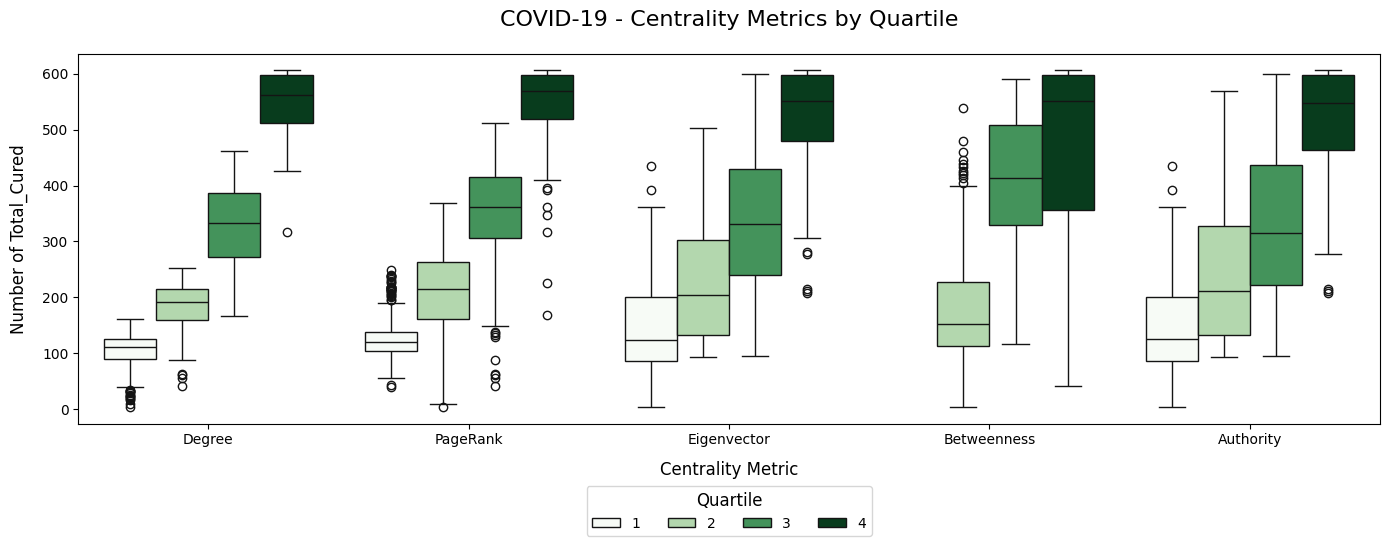

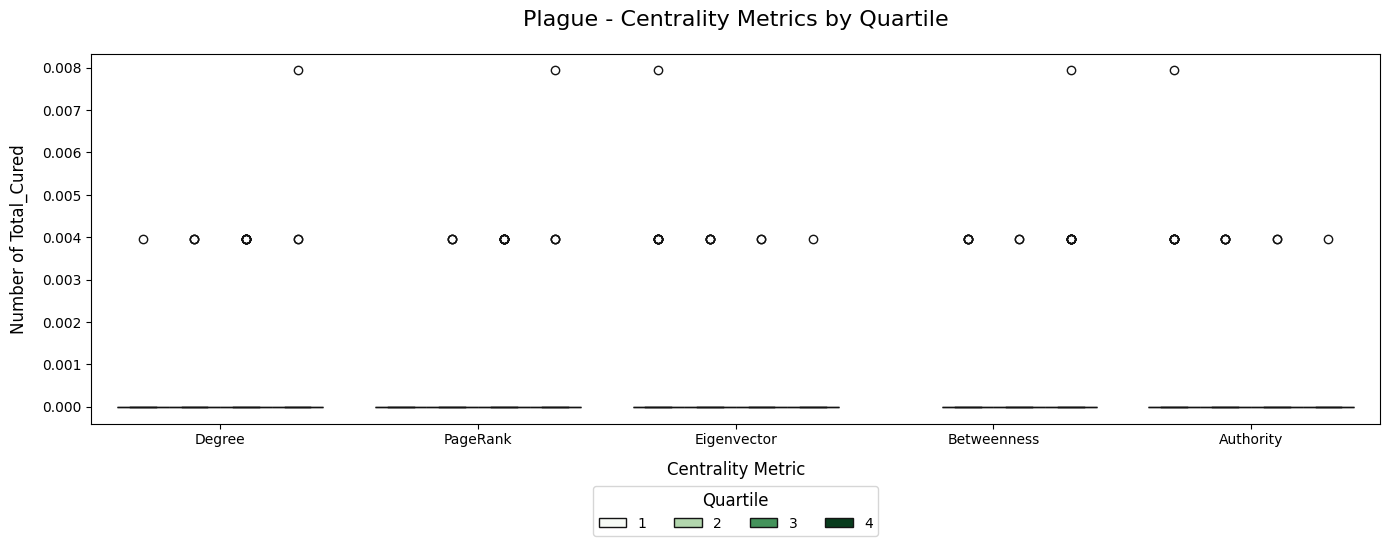

In [ ]:
# Genera i grafici MORTI per COVID-19 e peste
plot_quartile_correlation(merged_covid_df.copy(), 'COVID-19', centrality_metrics, y_measure='Total_Cured', palette='Greens')
plot_quartile_correlation(merged_plague_df.copy(), 'Plague', centrality_metrics, y_measure='Total_Cured', palette='Greens')

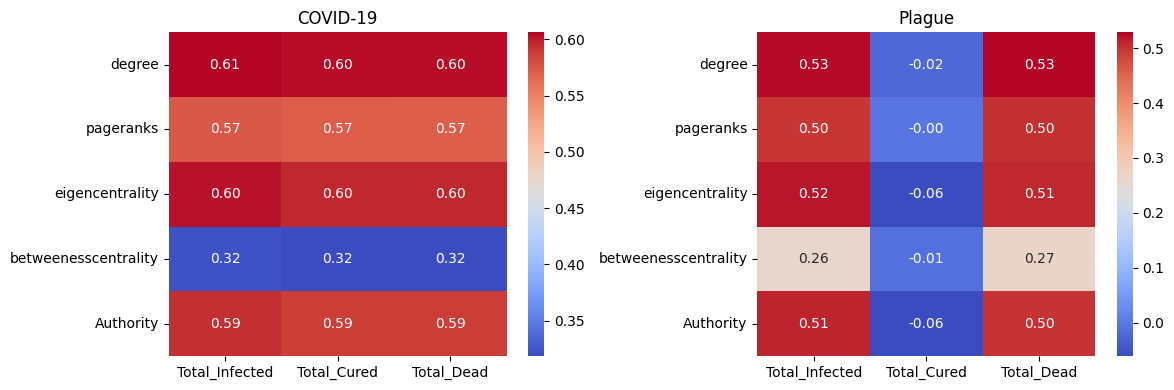

In [ ]:
heatmap_centrality_vs_avg(merged_covid_df, merged_plague_df)

##Analisi label

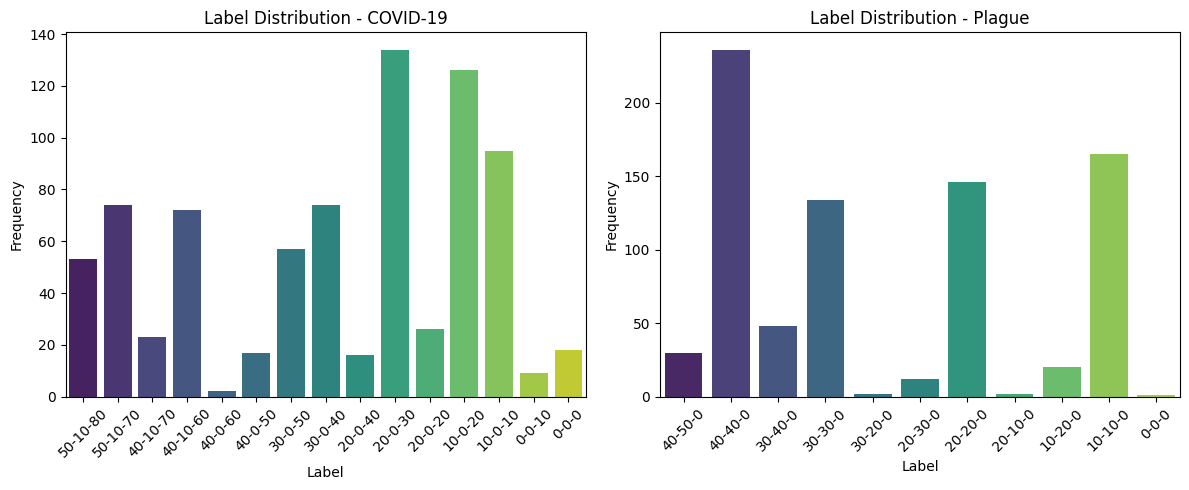

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

hist_label(merged_covid_df, axes[0], title='Label Distribution - COVID-19')
hist_label(merged_plague_df, axes[1], title='Label Distribution - Plague')

plt.tight_layout()
plt.show()

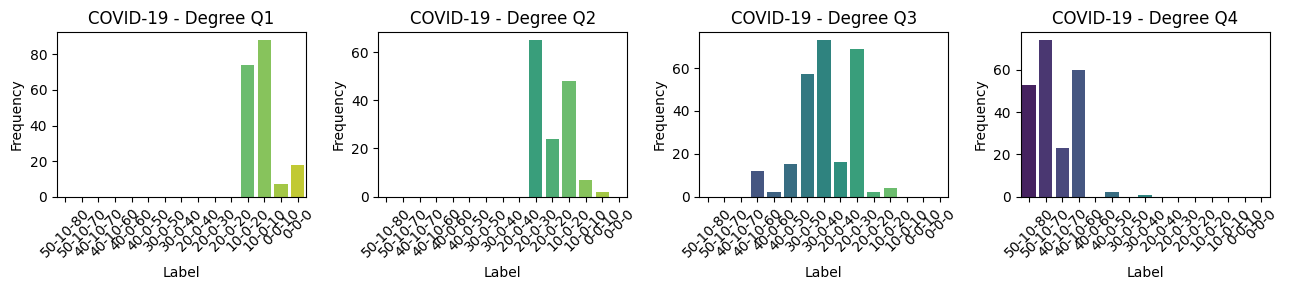

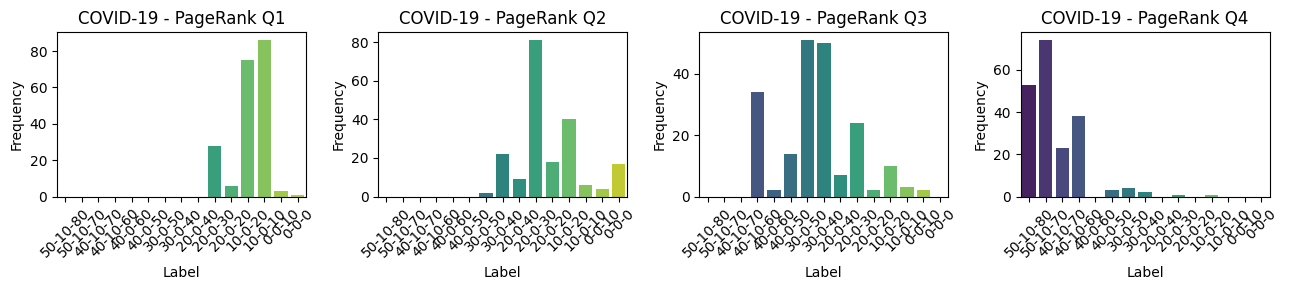

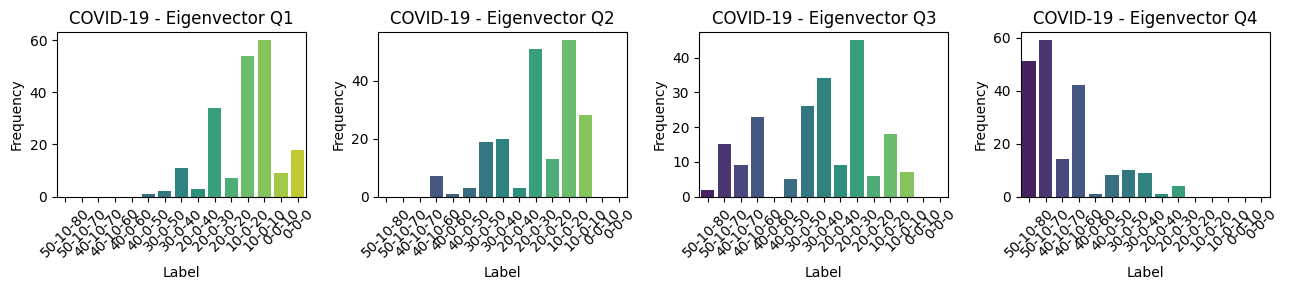

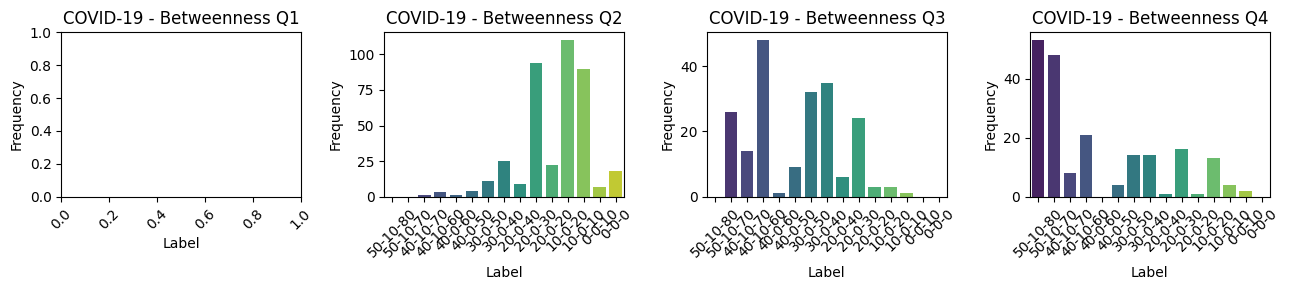

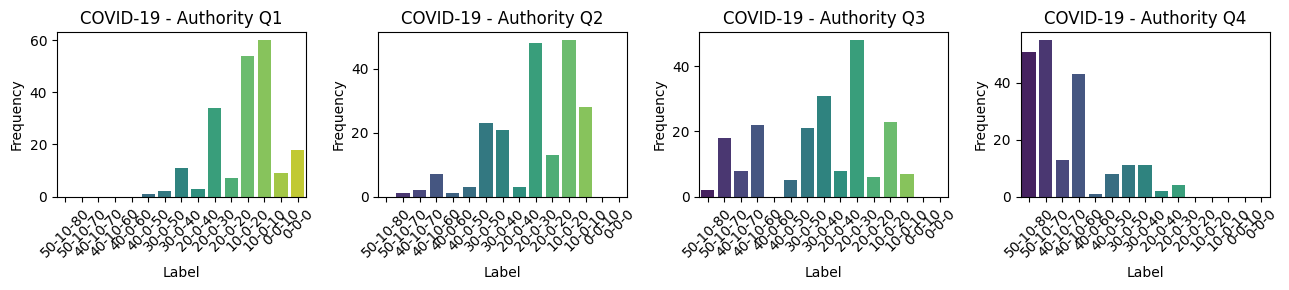

In [ ]:
base_df = merged_covid_df
for metric in centrality_metrics:
    # Crea una figura con due subplot
    fig, axes = plt.subplots(1, 4, figsize=(13, 3))
    for n in range(4):
      df = filter_quartile(base_df.copy(), metric, int(n+1))
      label_order = sorted(base_df['Etichetta'].unique(), reverse=True)
      hist_label(df, axes[n], title=f'COVID-19 - {label_map.get(metric)} Q{n+1}', label_order=label_order)
    plt.tight_layout()
    plt.show()

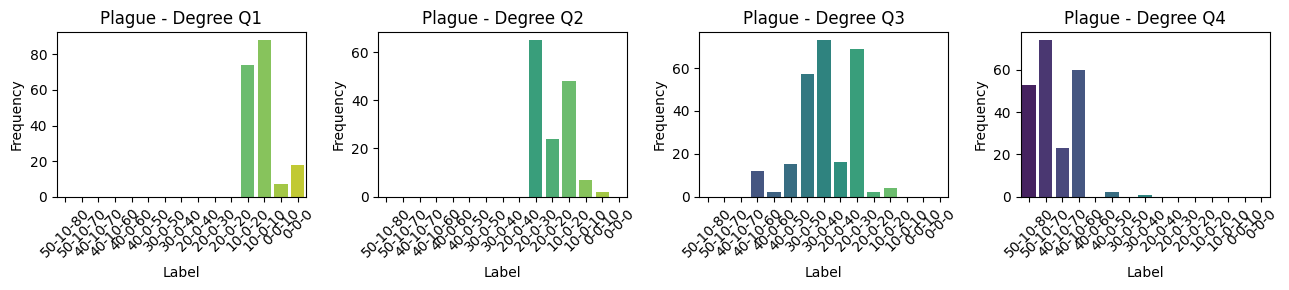

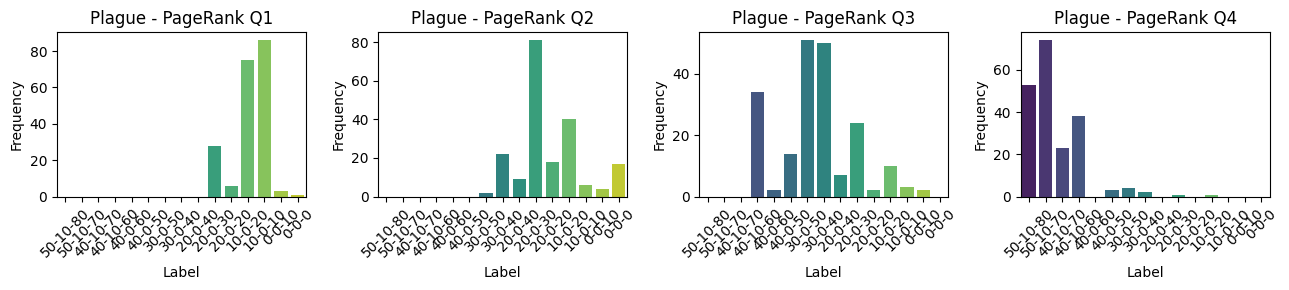

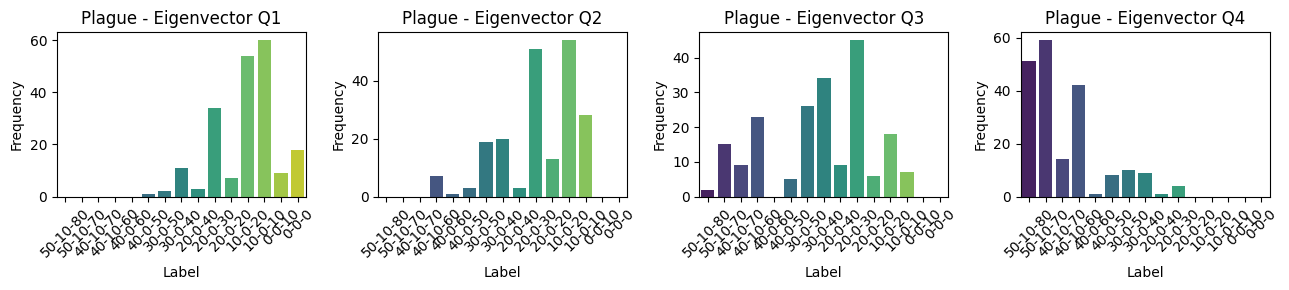

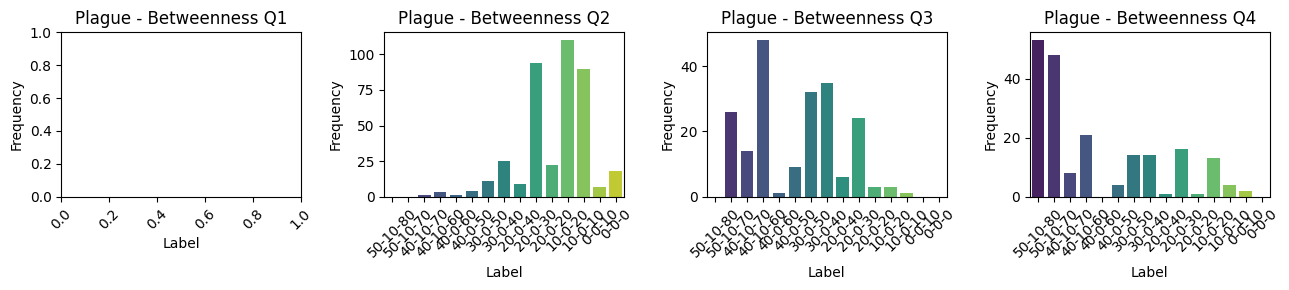

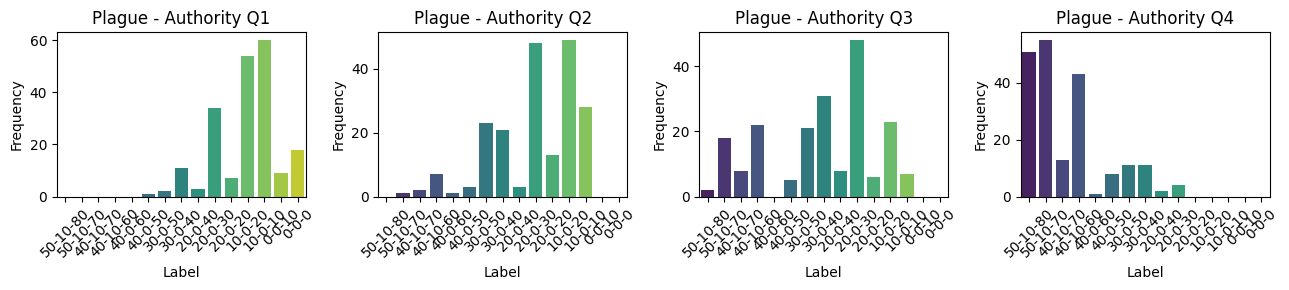

In [ ]:
base_df = merged_covid_df
for metric in centrality_metrics:
    # Crea una figura con due subplot
    fig, axes = plt.subplots(1, 4, figsize=(13, 3))
    for n in range(4):
      df = filter_quartile(base_df.copy(), metric, int(n+1))
      label_order = sorted(base_df['Etichetta'].unique(), reverse=True)
      hist_label(df, axes[n], title=f'Plague - {label_map.get(metric)} Q{n+1}', label_order=label_order)
    plt.tight_layout()
    plt.show()

##Correlazione delle label

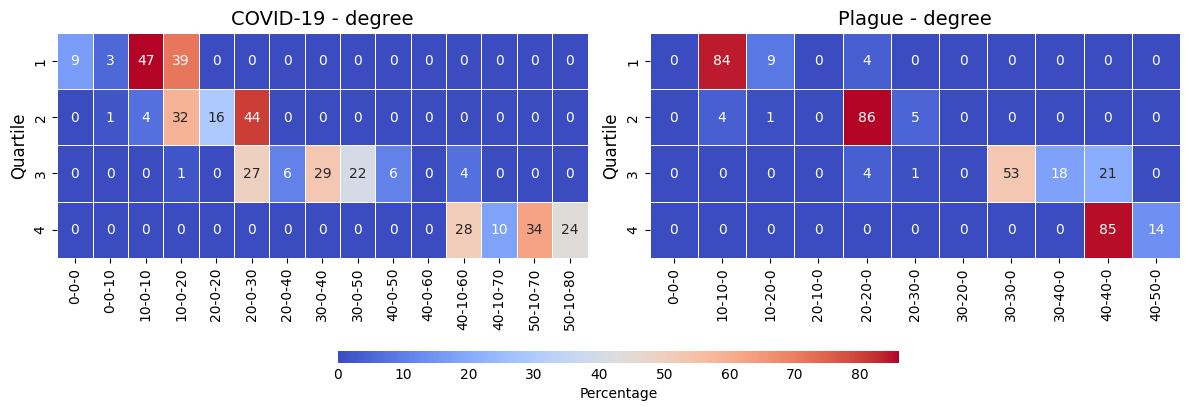

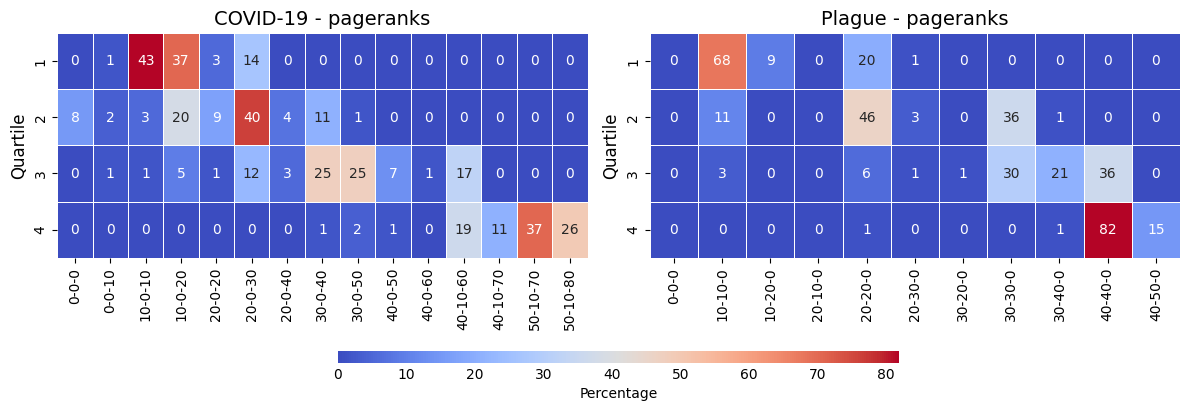

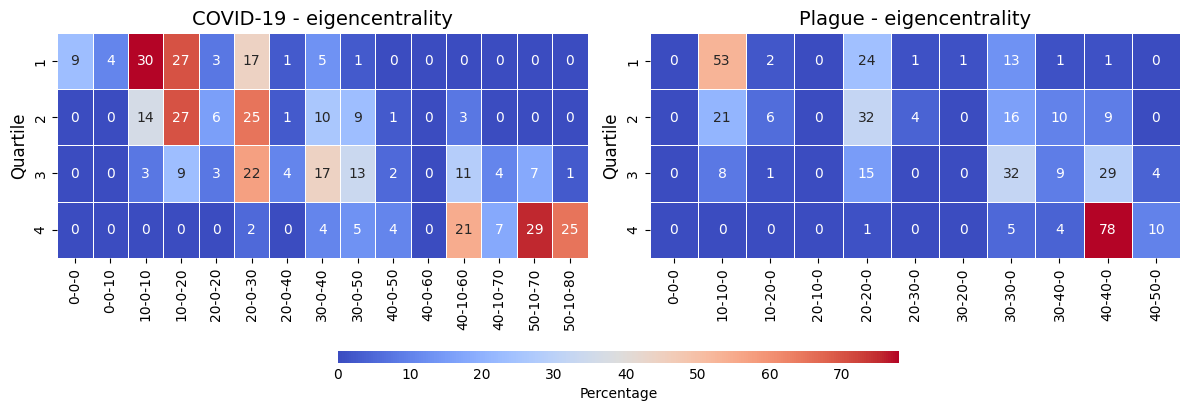

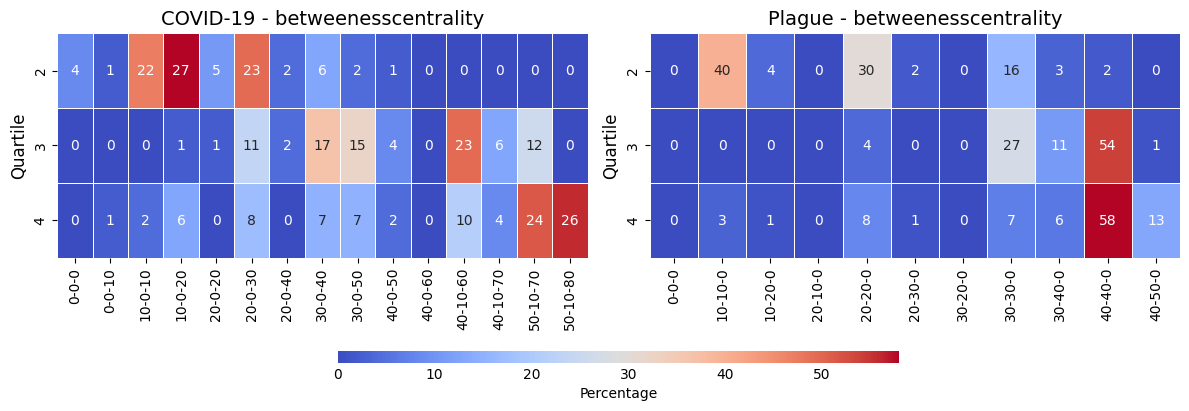

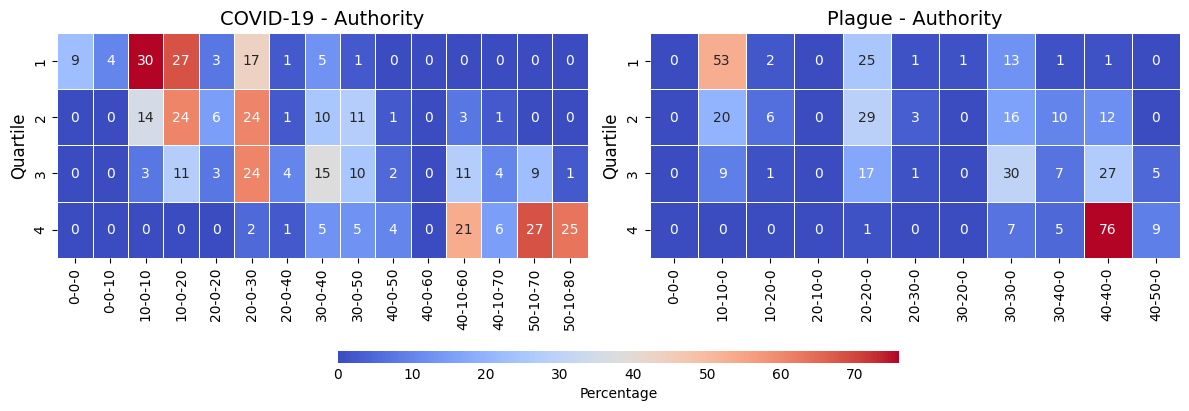

In [ ]:
for metric in centrality_metrics:
    # Calcola i quartili per la metrica
    closeness_quartiles = merged_covid_df[metric].quantile([0.25, 0.50, 0.75])

    # Aggiungi la colonna 'Quartile' ai DataFrame
    merged_covid_df['Quartile'] = merged_covid_df[metric].apply(lambda x: get_quartile(x, closeness_quartiles))
    merged_plague_df['Quartile'] = merged_plague_df[metric].apply(lambda x: get_quartile(x, closeness_quartiles))

    # Crea tabelle di contingenza
    covid_contingency = pd.crosstab(merged_covid_df['Quartile'], merged_covid_df['Etichetta'])
    plague_contingency = pd.crosstab(merged_plague_df['Quartile'], merged_plague_df['Etichetta'])

    # Normalizza i dati per riga in percentuale
    covid_contingency_norm = (covid_contingency.div(covid_contingency.sum(axis=1), axis=0) * 100).astype(int)
    plague_contingency_norm = (plague_contingency.div(plague_contingency.sum(axis=1), axis=0) * 100).astype(int)

    # Crea annotazioni per includere sia il valore percentuale che assoluto
    covid_annotations = covid_contingency_norm.astype(str)
    plague_annotations = plague_contingency_norm.astype(str)

    # Crea i grafici
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Heatmap per COVID-19
    sns.heatmap(
        covid_contingency_norm, annot=covid_annotations, fmt="", cmap="coolwarm", cbar_kws={'label': 'Percentage'},
        ax=axes[0], linewidths=0.5, cbar=False
    )
    axes[0].set_title(f'COVID-19 - {metric}', fontsize=14)
    axes[0].set_ylabel("Quartile", fontsize=12)
    axes[0].set_xlabel("", fontsize=1)

    # Heatmap per Plague
    sns.heatmap(
        plague_contingency_norm, annot=plague_annotations, fmt="", cmap="coolwarm", cbar_kws={'label': 'Percentage'},
        ax=axes[1], linewidths=0.5, cbar=False
    )
    axes[1].set_title(f'Plague - {metric}', fontsize=14)
    axes[1].set_ylabel("Quartile", fontsize=12)
    axes[1].set_xlabel("", fontsize=1)

    # Ottimizza il layout e mostra i grafici
    plt.tight_layout()
    # Aggiungi la colormap a fig con intervallo 0-100 e orientamento orizzontale
    cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='horizontal', shrink=0.5, pad=0.25, aspect=50,
                        label='Percentage', ticks=range(0, 101, 10))
    cbar.outline.set_visible(False)  # Rimuovi il contorno
    cbar.ax.tick_params(size=0)  # Rimuovi le tacche dei tick

    plt.show()